# Time Series Analysisn and Forecasting

In [1]:
# Importing basic libraries for time series analysis
import pandas as pd
# Making some setting or pandas to show 100 rows
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Setting rcParams
plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

# Importing from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
# Importing some linear models for capturing trend
from sklearn.linear_model import LinearRegression
#  Importing some non-linear model for capturing complex patterns
from xgboost import XGBRegressor
# Importing evaluation matrix
from math import sqrt
from sklearn.metrics import mean_squared_log_error
# Importing from statsmodels
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

Now we will import our datasets that were given

In [2]:
# Import the training dataset
store_sales = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv",
    index_col='id',
                          dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    )

# Importing oil prices dataset
oil_prices = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv",
                         parse_dates=['date'],
                         infer_datetime_format=True)

# Importing holidays dataset
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv',
                       parse_dates=['date'],
                       infer_datetime_format=True)

# Importing the testing dataset
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
                   parse_dates=['date'],
                    dtype={
                    'store_nbr': 'category',
                   'family': 'category',
                   'onpromotion': 'uint32',
                  },
                   infer_datetime_format=True)



/tmp/ipykernel_26/3983497624.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv",
/tmp/ipykernel_26/3983497624.py:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  oil_prices = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv",
/tmp/ipykernel_26/3983497624.py:20: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdep

In [3]:
# Make dates column periodic for oil_dataset, sales_dataset and test dataset
oil_prices['date'] = oil_prices.date.dt.to_period("D")
store_sales['date'] = store_sales.date.dt.to_period('D')
test['date'] = test.date.dt.to_period('D')
holidays['date'] = holidays.date.dt.to_period('D')

# Converting store_nbr, family, date to index
store_sales = store_sales.set_index(['store_nbr','family','date']).sort_index()
test = test.set_index(['store_nbr','family','date']).sort_index()


# We will convert the sales dataset set into average sales dataset set for each day
# As the dataset contains the sales for each category and store
# It will help us in different kinds of analysis
store_sales_s = store_sales.groupby('date').mean()
# Creating a time dummy feature for analysis
store_sales_s['time'] = np.arange(len(store_sales_s))
store_sales_s = store_sales_s.reset_index()

# Droppring holidays havig Transferred = True as they were normal days because there event was transferred to some other date
holidays = holidays[holidays['date'] >= '2013-01-01']
# Taking only date and description of the holiday
holidays = holidays[['date','locale', 'description']]

There are three datasets that we can use for training
1) The original store sales dataset that contains the historical sales data for all stores and product categories

2) The oil prices dataset that contains the oil prices of the country from 2012 to 2017-08-31 for evey day

3) The events(holidays) that occured in the country form 2013 to 2017-08-31

Fist we will check if holidays and oil prices have any impact on sales of the super store

# Sales and Oil prices

In [4]:
# Now we will merge the store_sales_s dataset with the oil_prices dataset
store_sales_O = store_sales_s.merge(oil_prices, on='date', how='left')
store_sales_O.isna().sum()

date             0
sales            0
onpromotion      0
time             0
dcoilwtico     521
dtype: int64

We can see that the oil prices for many dates is missing. we will impute them first with foreword and backword fill as oil prices on one days are close to the oil prices before that days or the day next to it.

/tmp/ipykernel_26/3874764942.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_sales_O.dcoilwtico.fillna(method='ffill', inplace=True)
/tmp/ipykernel_26/3874764942.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  store_sales_O.dcoilwtico.fillna(method='ffill', inplace=True)
/tmp/ipykernel_26/3874764942.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace 

date           0
sales          0
onpromotion    0
time           0
dcoilwtico     0
dtype: int64


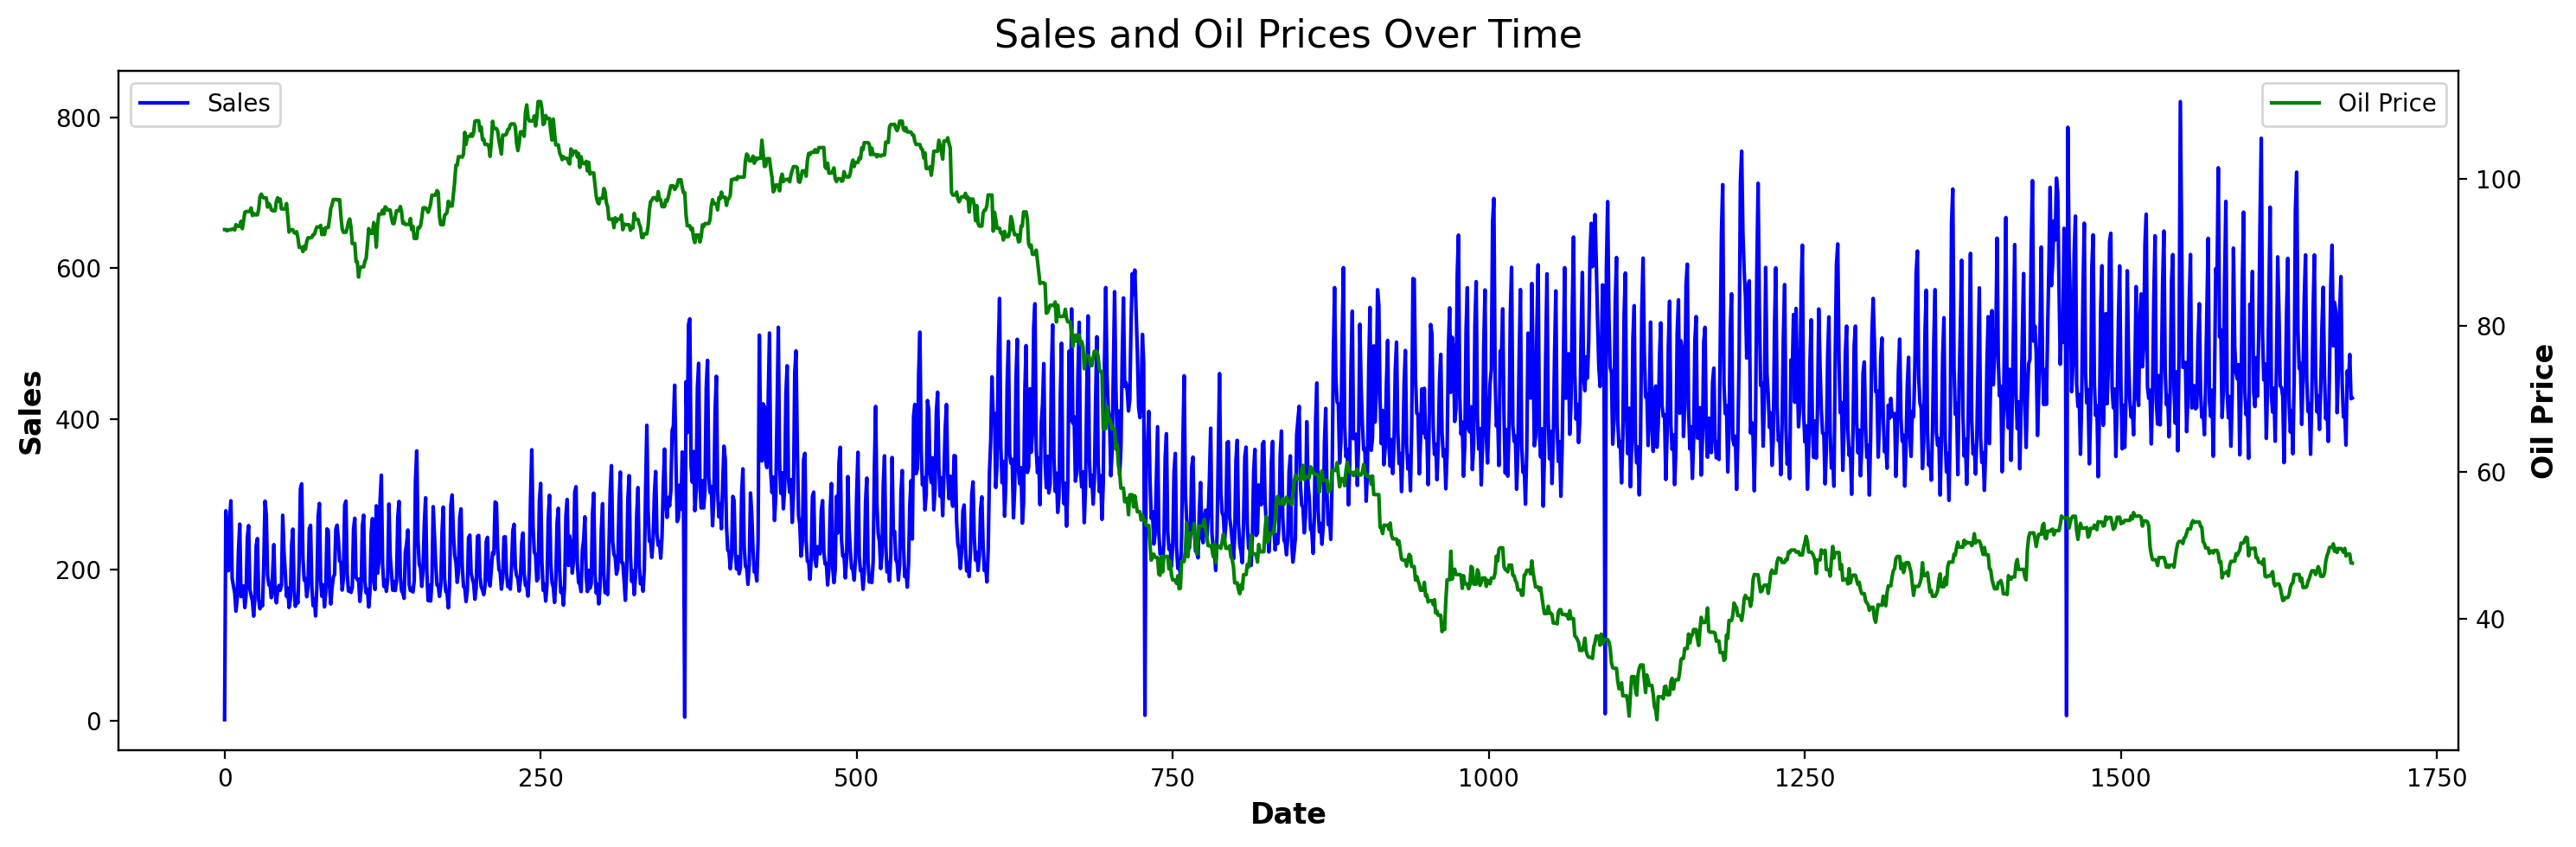

In [5]:
# Imputing the missing oil price values with forword fill and backward fill
store_sales_O.dcoilwtico.fillna(method='ffill', inplace=True)
store_sales_O.dcoilwtico.fillna(method='bfill', inplace=True)
print(store_sales_O.isna().sum())


# Plotting using pandas.plot()
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot 'sales' on the first y-axis (ax1)
store_sales_O['sales'].plot(ax=ax1, color='blue', label='Sales')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Date')

# Creating a secondary y-axis for 'dcoilwtico' (oil prices)
ax2 = ax1.twinx()
store_sales_O['dcoilwtico'].plot(ax=ax2, color='green', label='Oil Price')
ax2.set_ylabel('Oil Price')

# Displaying the legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Sales and Oil Prices Over Time')
plt.show()


Now it looks natural.

Now lets check the correlation between the sales and oil_prices to check if we can use it for forecasitng


<Axes: xlabel='dcoilwtico', ylabel='sales'>

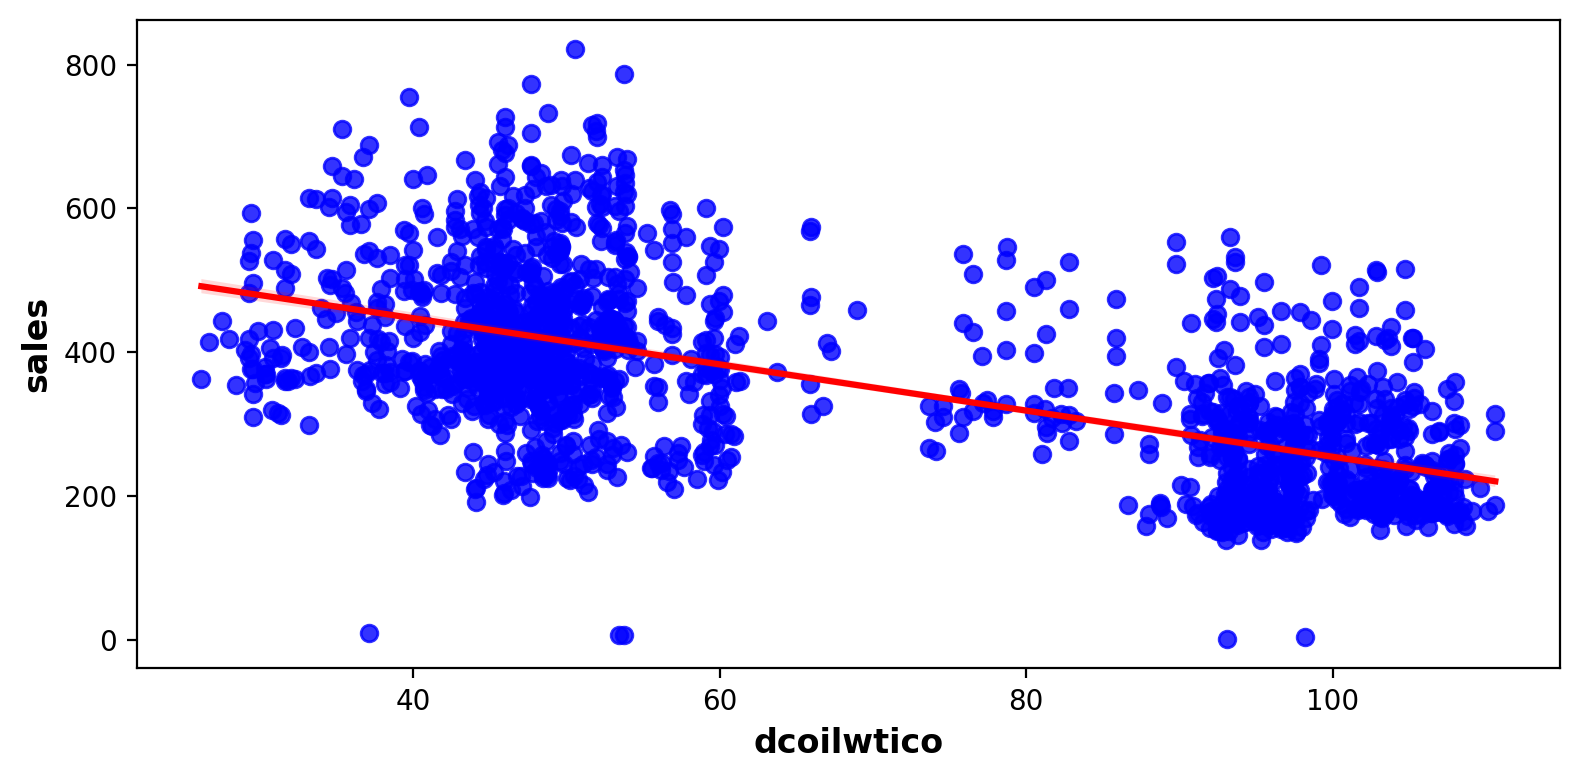

In [6]:
# Plotting the regression plot between sales and oil price
plt.figure(figsize=(8, 4))
sns.regplot(data=store_sales_O, x='dcoilwtico', y='sales',color='blue', line_kws={'color': 'red'})

We can see that with the increase of oilprices the sales decrease.
We will use it in forecasting

In [7]:
oil_prices.set_index('date', inplace=True)
oil_prices

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20
...                ...
2017-08-25       47.65
2017-08-28       46.40
2017-08-29       46.46
2017-08-30       45.96
2017-08-31       47.26

[1218 rows x 1 columns]

# Sales and Holidays

Now we will check the relationship between sales and holidays to see if there is significant relation.

Here where have three types of events on the basis of locale(National, Regional, Local). If we use all of them in training the model we will have a lot of feature. so we will do some analysis to check which of three has the most effect on the sales and we will keep that one

In [8]:
store_sales_s

date       sales  onpromotion  time
0     2013-01-01    1.409438     0.000000     0
1     2013-01-02  278.390808     0.000000     1
2     2013-01-03  202.840195     0.000000     2
3     2013-01-04  198.911163     0.000000     3
4     2013-01-05  267.873260     0.000000     4
...          ...         ...          ...   ...
1679  2017-08-11  463.733856     7.956790  1679
1680  2017-08-12  444.798309     4.664422  1680
1681  2017-08-13  485.768616     5.209315  1681
1682  2017-08-14  427.004730     4.513468  1682
1683  2017-08-15  427.980896     5.951178  1683

[1684 rows x 4 columns]

In [9]:
# Splitting the holidays in three dataset on the basis of locale
holidays_N = holidays[holidays.locale == 'National']
holidays_R = holidays[holidays.locale == 'Regional']
holidays_L = holidays[holidays.locale == 'Local']

# Dropping the locale column as we don't need it anymore
holidays_N.drop('locale', axis=1, inplace=True)
holidays_R.drop('locale', axis=1, inplace=True)
holidays_L.drop('locale', axis=1, inplace=True)

# Making three dataset each having store_sales_s and different holidays datasets to analyze the effect of holidays on sales
store_sales_N = store_sales_s.merge(holidays_N, on='date', how='left')
store_sales_R = store_sales_s.merge(holidays_R, on='date', how='left')
store_sales_L = store_sales_s.merge(holidays_L, on='date', how='left')

/tmp/ipykernel_26/3421546183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_N.drop('locale', axis=1, inplace=True)
/tmp/ipykernel_26/3421546183.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_R.drop('locale', axis=1, inplace=True)
/tmp/ipykernel_26/3421546183.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_L.drop('locale', axis=1, inplace=True)


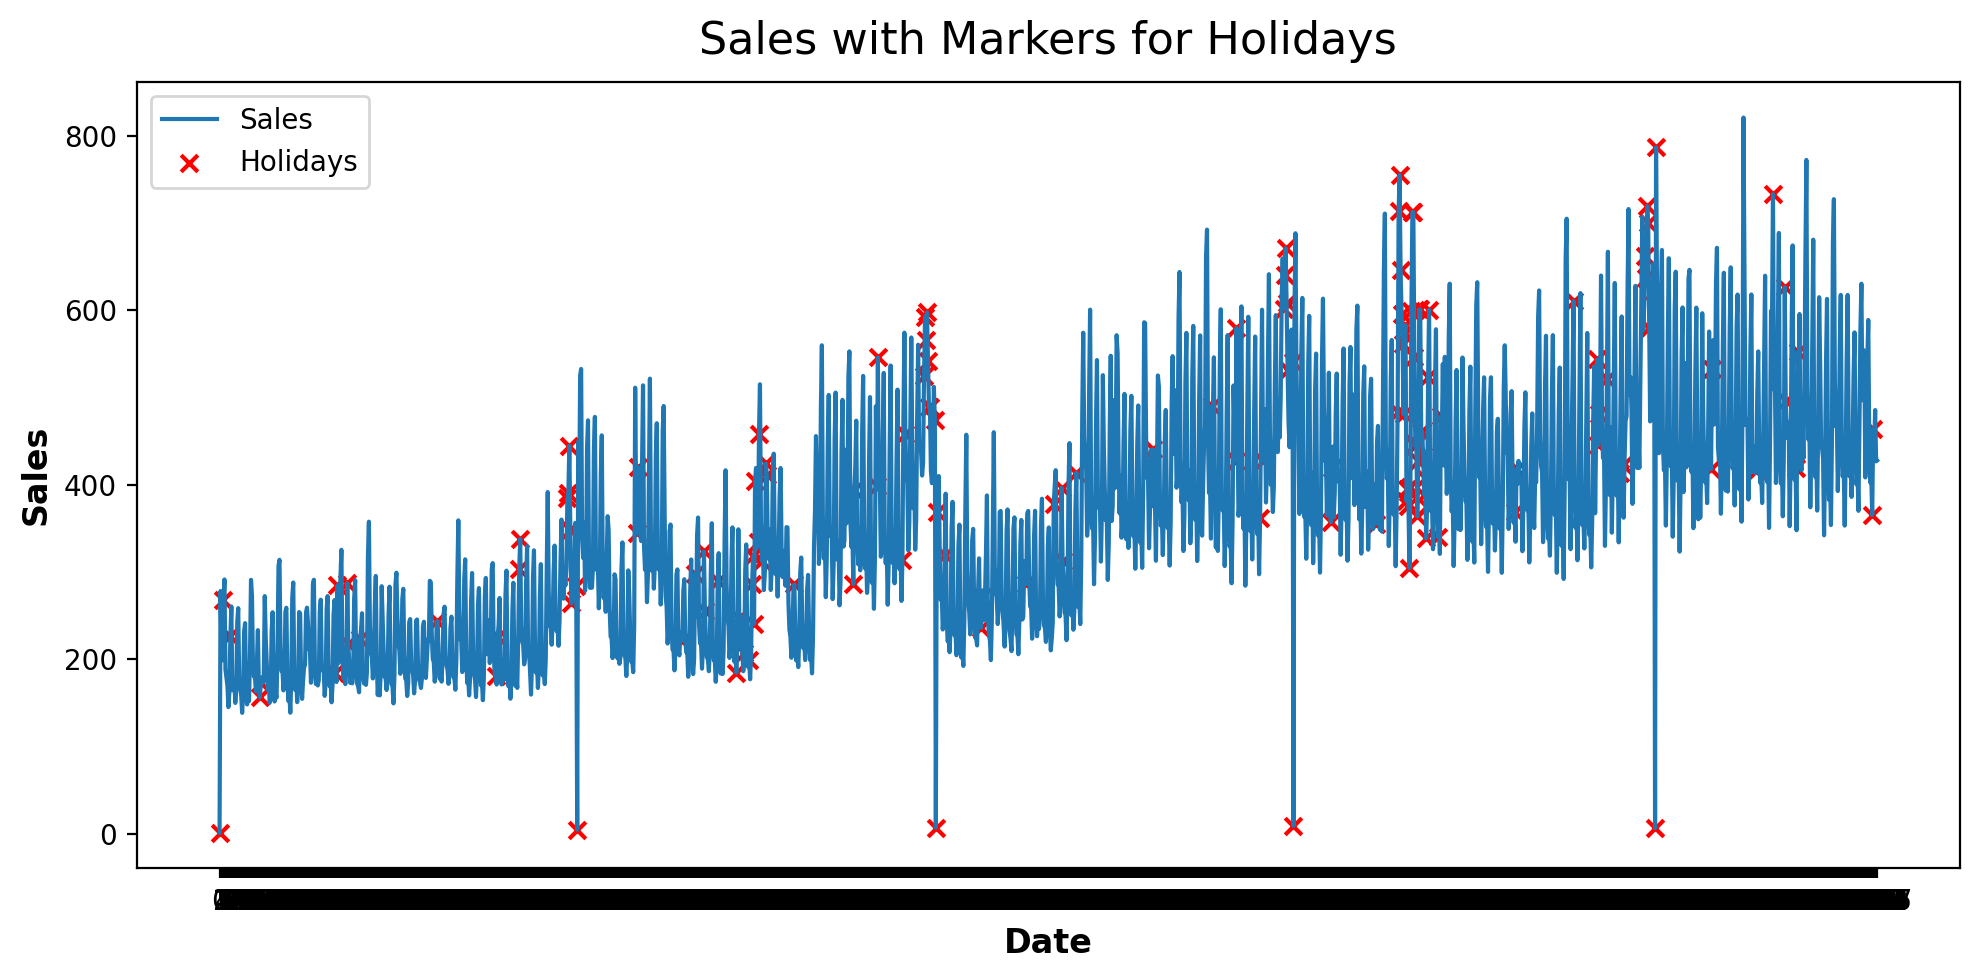

In [10]:
plt.figure(figsize=(10, 5))
store_sales_N.index = store_sales_N.index.astype(str)
plt.plot(store_sales_N['sales'], linestyle='-', label='Sales')

# Marking holidays on the plot
holidays_1 = store_sales_N[store_sales_N['description'].notna()]
plt.scatter(holidays_1.index, holidays_1['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

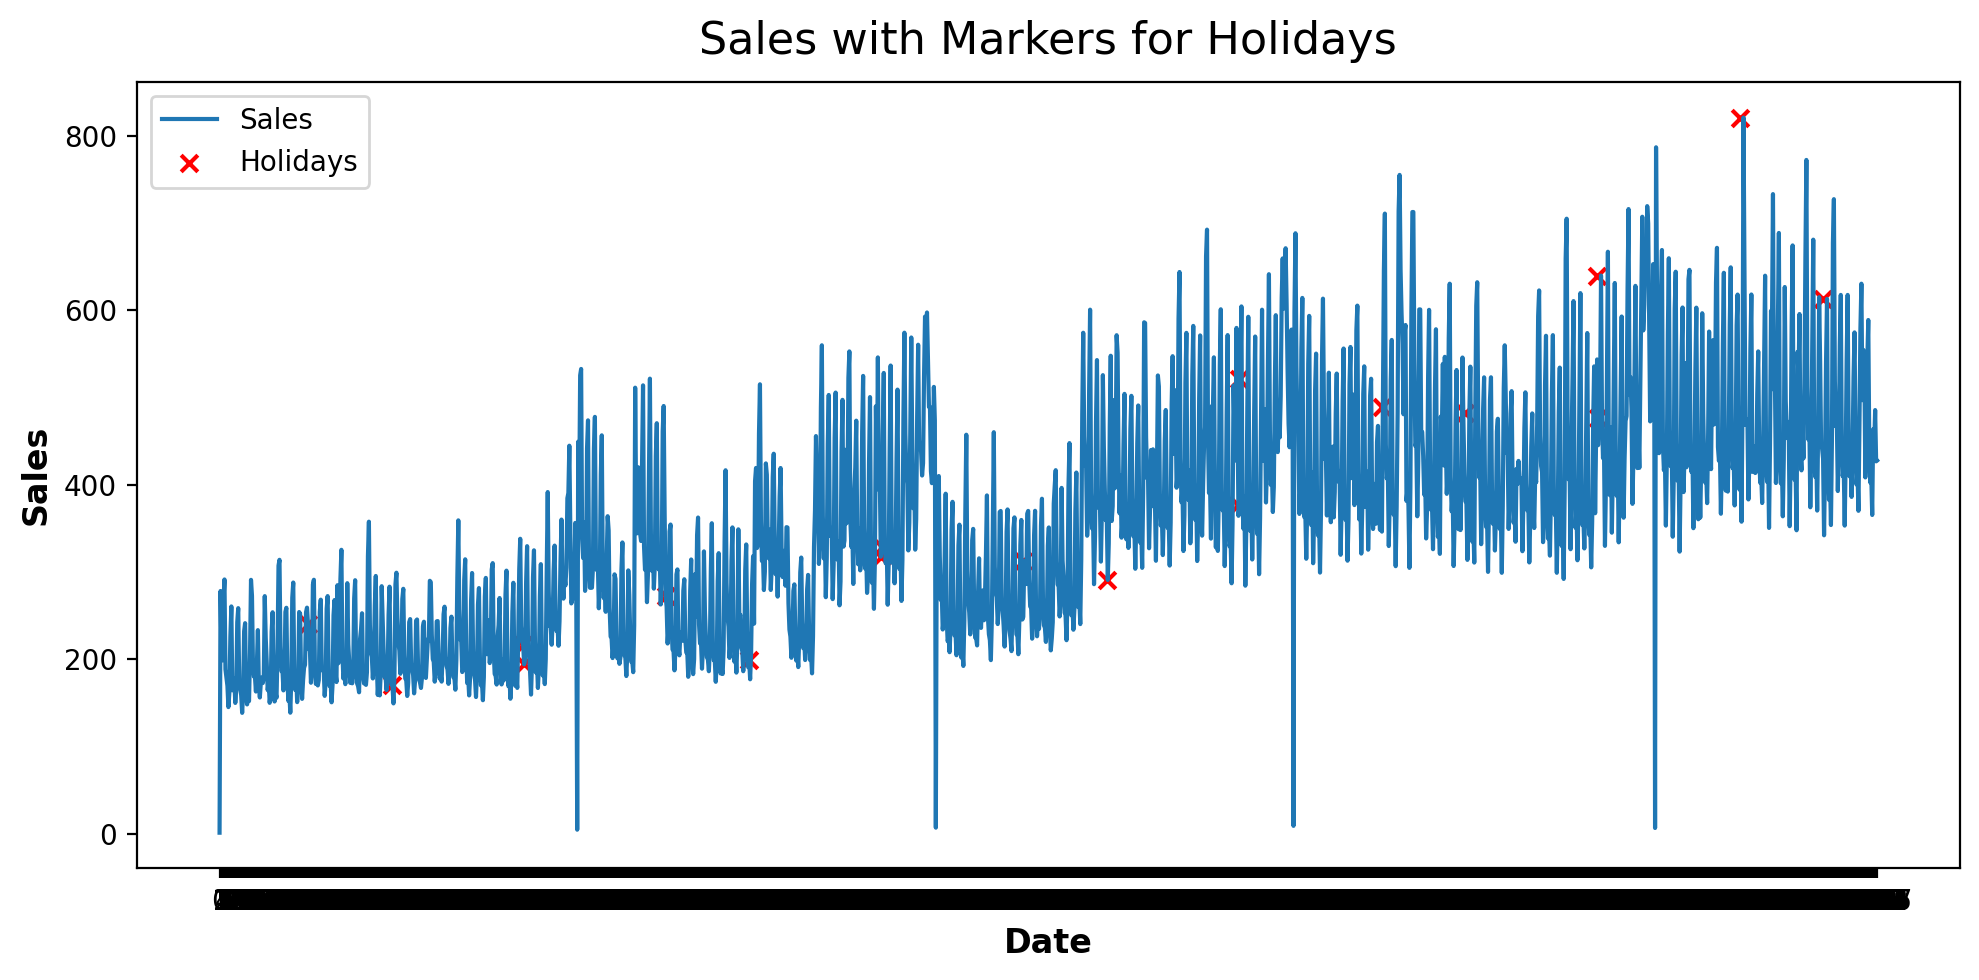

In [11]:
plt.figure(figsize=(10, 5))
store_sales_N.index = store_sales_N.index.astype(str)
plt.plot(store_sales_N['sales'], linestyle='-', label='Sales')

# Marking holidays on the plot
holidays_2 = store_sales_R[store_sales_R['description'].notna()]
plt.scatter(holidays_2.index, holidays_2['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

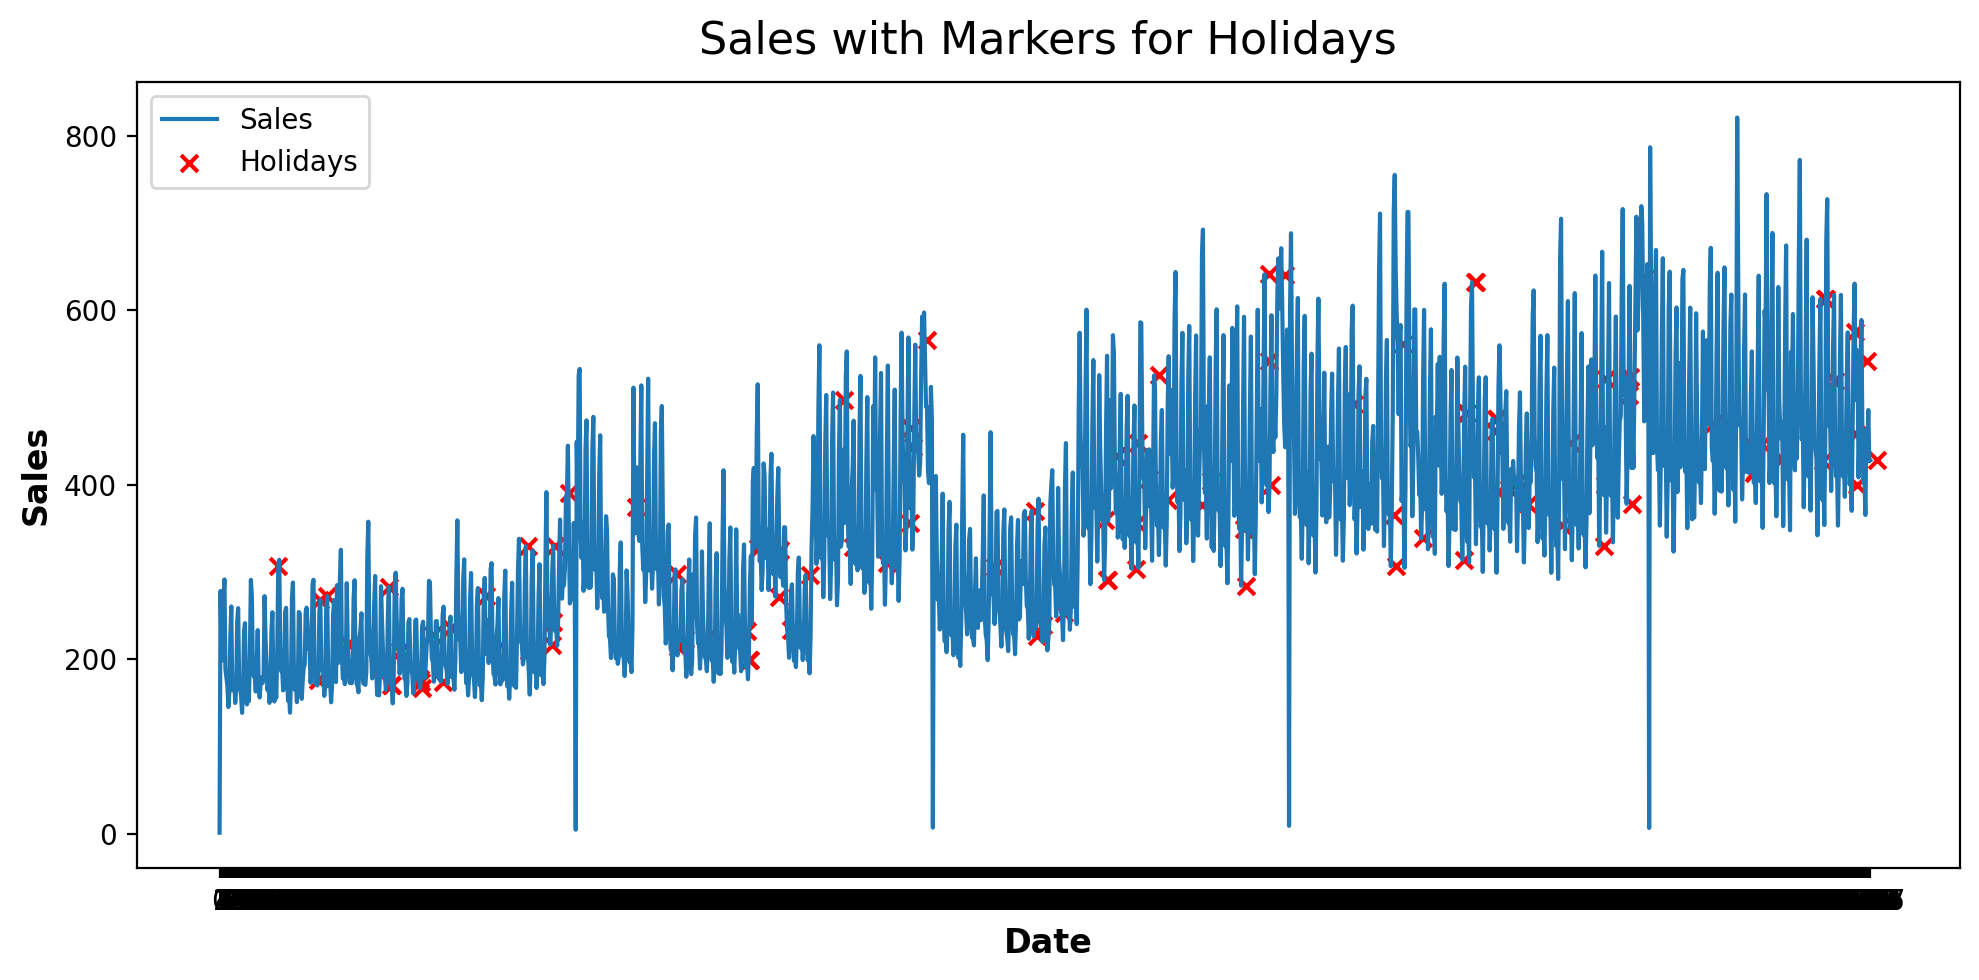

In [12]:
plt.figure(figsize=(10, 5))
store_sales_N.index = store_sales_N.index.astype(str)
plt.plot(store_sales_N['sales'], linestyle='-', label='Sales')

# Marking holidays on the plot
holidays_3 = store_sales_L[store_sales_L['description'].notna()]
plt.scatter(holidays_3.index, holidays_3['sales'], color='red', marker='x', label='Holidays')

# Customize the plot
plt.title('Sales with Markers for Holidays')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

We can see from the plots above that the most peaks in the sales are caused by national events so we will only take the naional events

In [13]:
holidays_N.drop_duplicates(subset='date', keep='first', inplace=True)
holidays_N.set_index('date', inplace=True)
OH = OneHotEncoder(sparse=False)
holidays_N_OH = pd.DataFrame(OH.fit_transform(holidays_N[['description']]), index=holidays_N.index, columns=OH.get_feature_names_out(['description']))

/tmp/ipykernel_26/2685772596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_N.drop_duplicates(subset='date', keep='first', inplace=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Checking the outliers

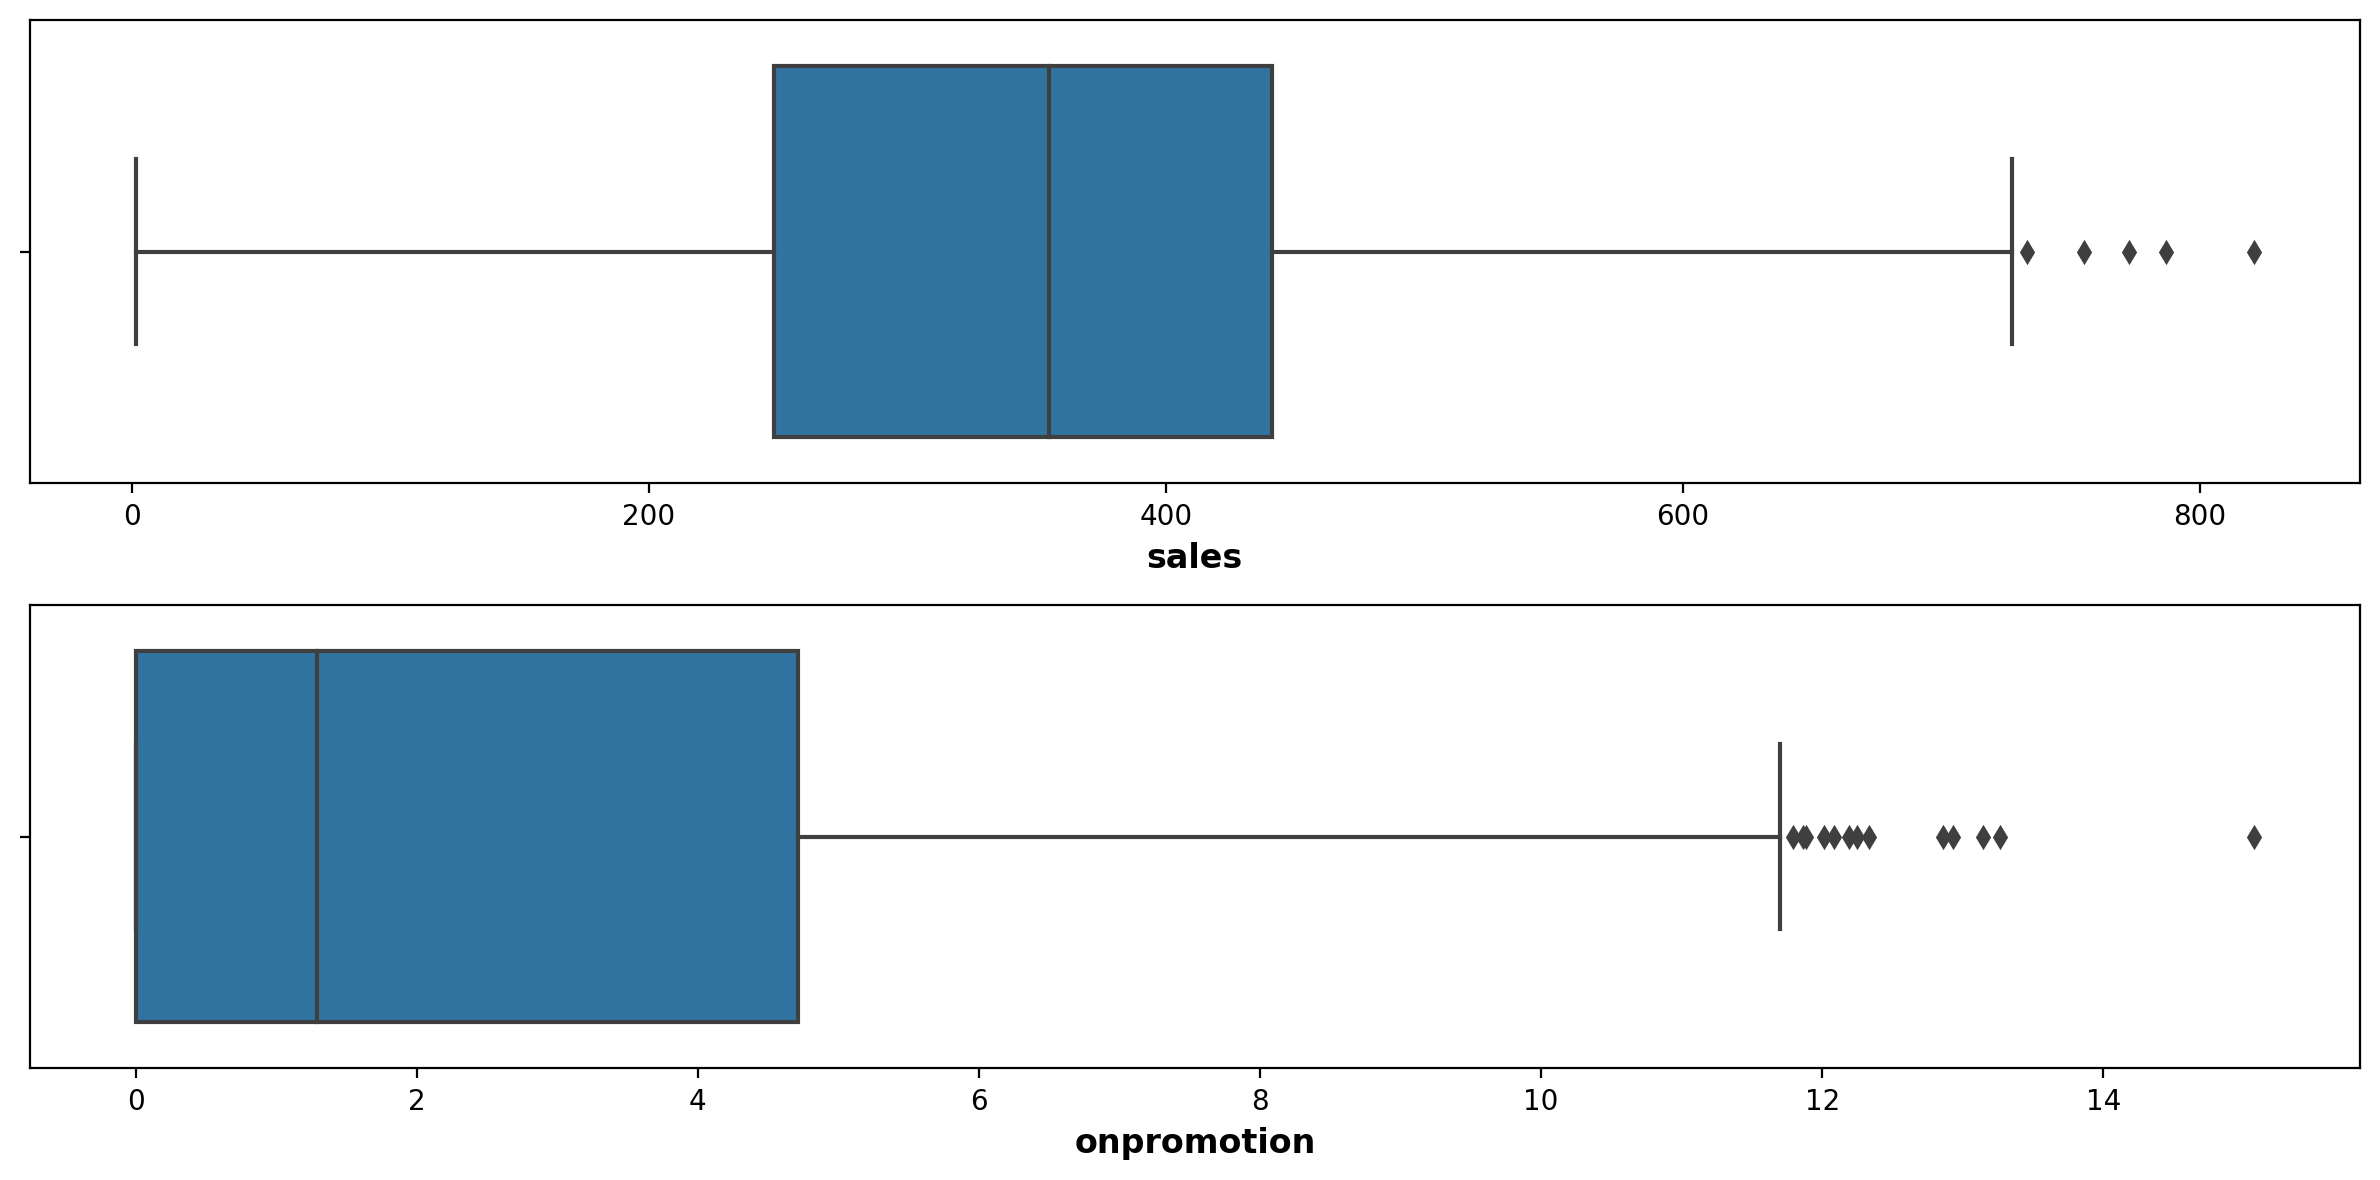

In [14]:
# Check the outliers in the sales using histogram and boxplot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sns.boxplot(data=store_sales_s, x='sales', ax=ax[0])
sns.boxplot(data=store_sales_s, x='onpromotion', ax=ax[1])  # Use ax[1] for the second plot

plt.show()

Let see the cause of these outliers.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

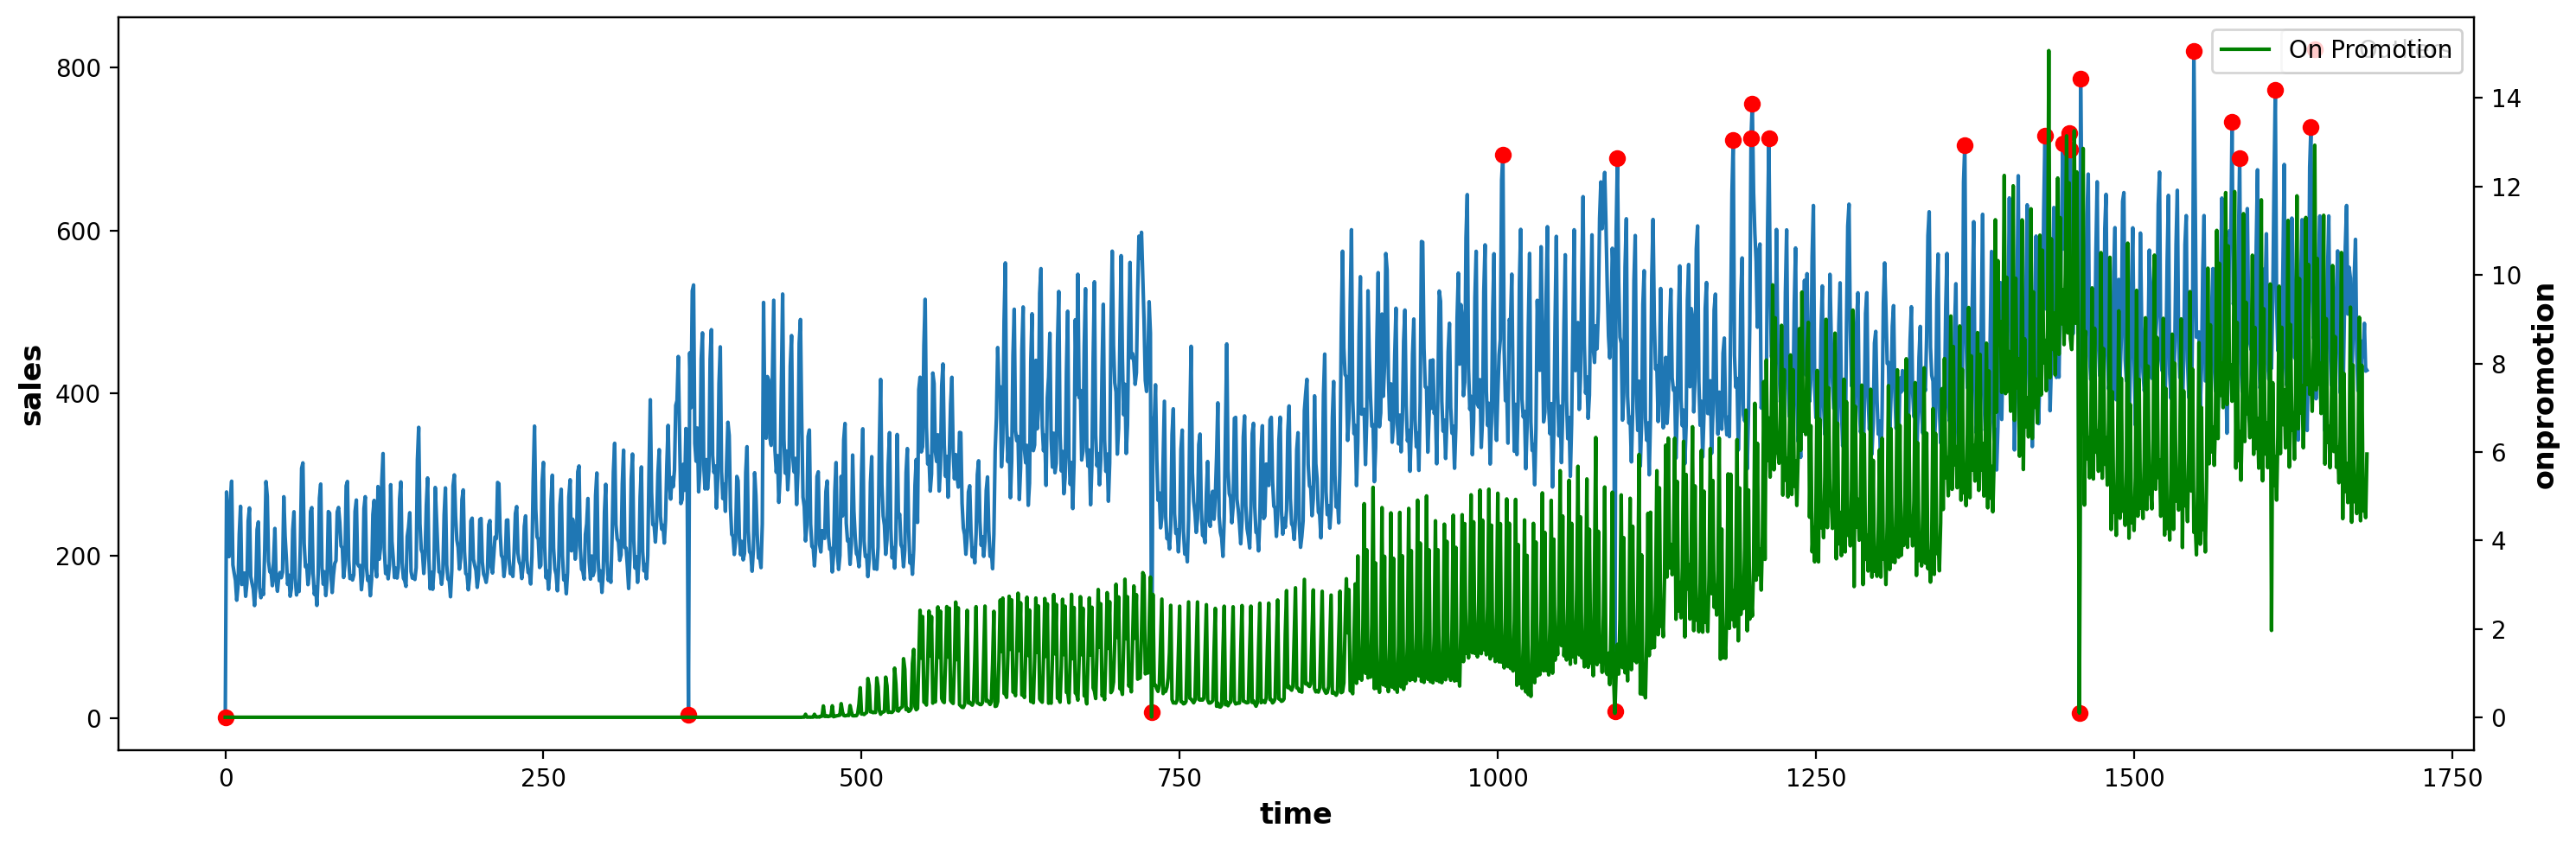

In [15]:
# Calculating the mean and standard deviation of the sales
mean_sales = store_sales_s['sales'].mean()
std_sales = store_sales_s['sales'].std()

# Seting a threshold for outliers (e.g., 2 standard deviations from the mean)
outlier_threshold = 2.5

# Identifying outliers
outliers = store_sales_s[(store_sales_s['sales'] > mean_sales + outlier_threshold * std_sales) |
                         (store_sales_s['sales'] < mean_sales - outlier_threshold * std_sales)]

# Creating a figure with a primary y-axis for sales
fig, ax1 = plt.subplots(figsize=(15, 5))
sns.lineplot(x='time', y='sales', data=store_sales_s, ax=ax1)
plt.errorbar(x=outliers['time'], y=outliers['sales'], fmt='ro', label='Outliers')
ax1.legend()

# Creating a secondary y-axis for onpromotion
ax2 = ax1.twinx()
sns.lineplot(x=store_sales_s['time'], y=store_sales_s['onpromotion'], data=store_sales_s, ax=ax2, color='green', label='On Promotion')
ax2.legend()

plt.show()


We can see that the outliers are mainly due to the promotion that were given and the events that occurred so we will leave them as such

# Sales and Onpromtion

Lets look at the relation between the onpromotion and sales

<Axes: xlabel='onpromotion', ylabel='sales'>

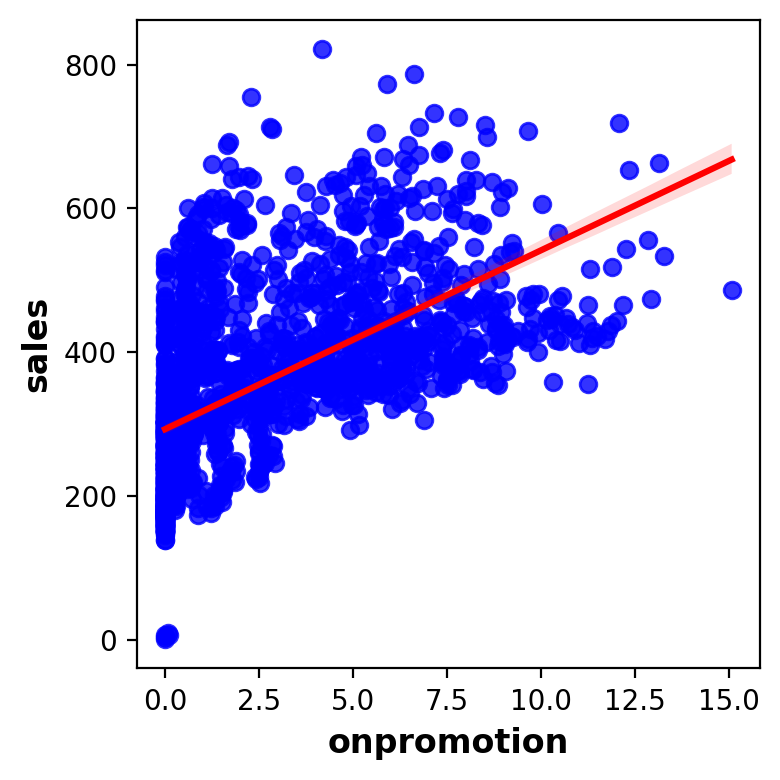

In [16]:
# Plotting the relationship between onpromotion and sales using a regplot
plt.figure(figsize=(4, 4))
sns.regplot(data=store_sales_s, x='onpromotion', y='sales',color='blue', line_kws={'color': 'red'})

There is a good relation between sales and promotions. I can be a good feature for forecasting the sales

# Trend

We will see the overall trend of the sales

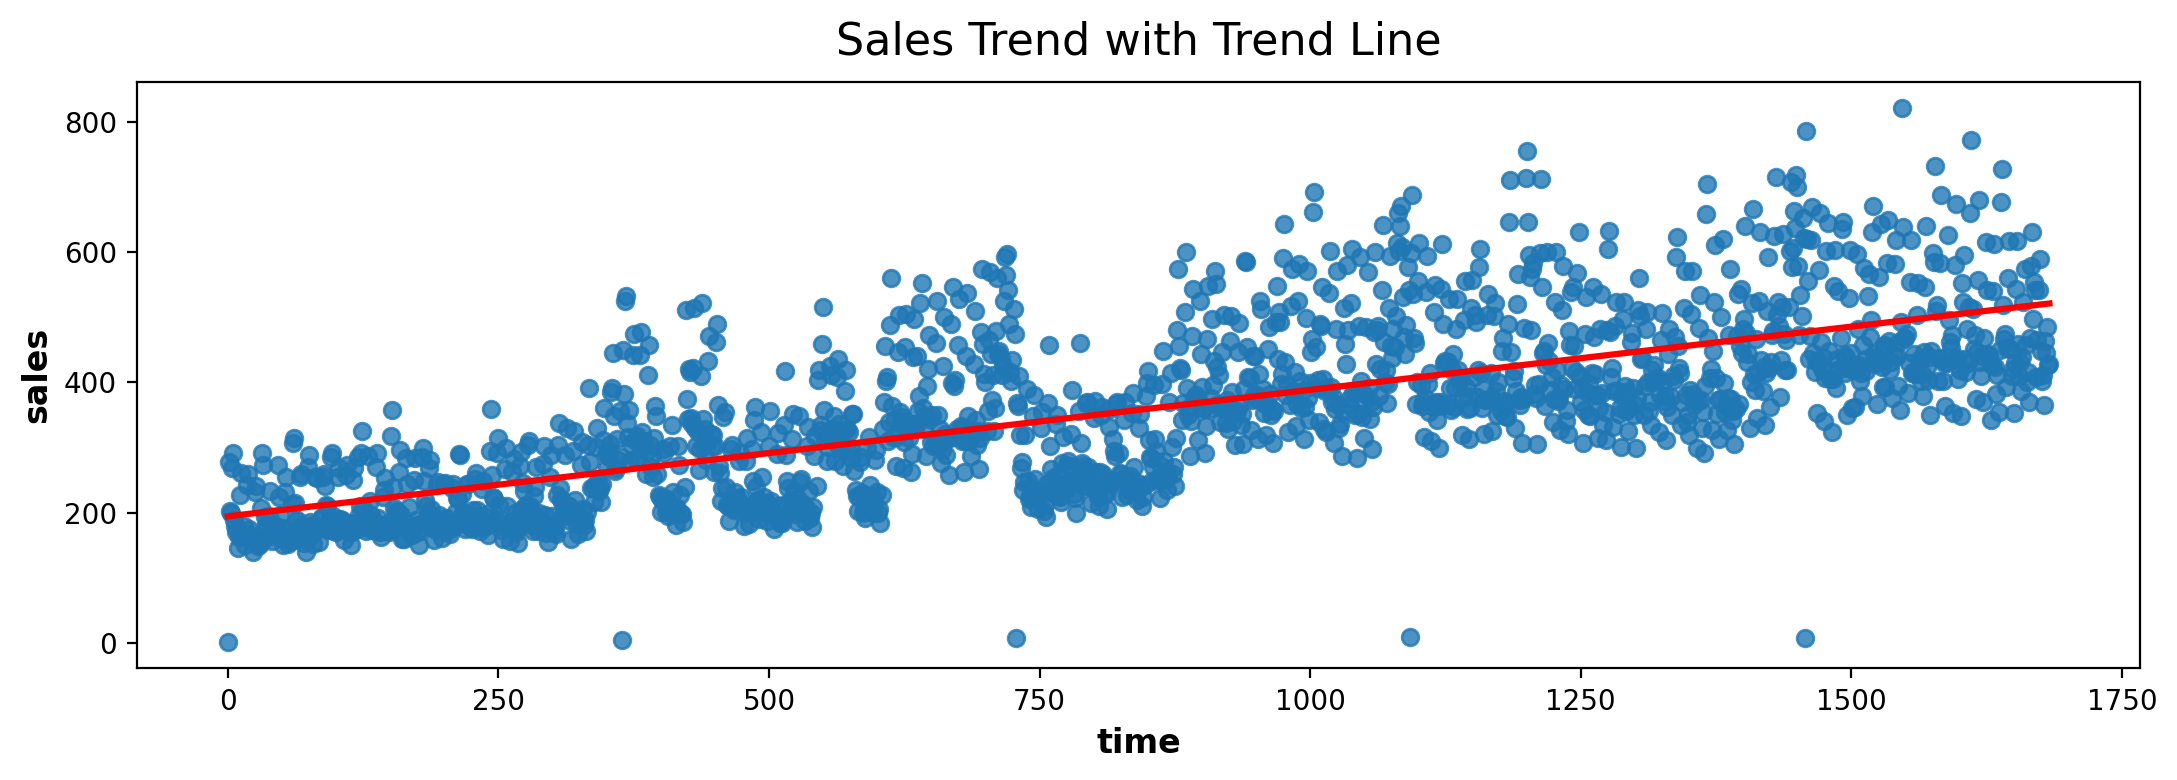

In [17]:
# Plotting the trend of the sales using lineplot
sns.regplot(data=store_sales_s, x='time', y='sales', ci=None, line_kws={"color": "red"})
plt.title('Sales Trend with Trend Line')
plt.show()


We can see we have over all upword trend of sales with respect to time

# Seasonlaity in data

Another component of time series is seasonality.

So lets check if there any seasonality in our sales data

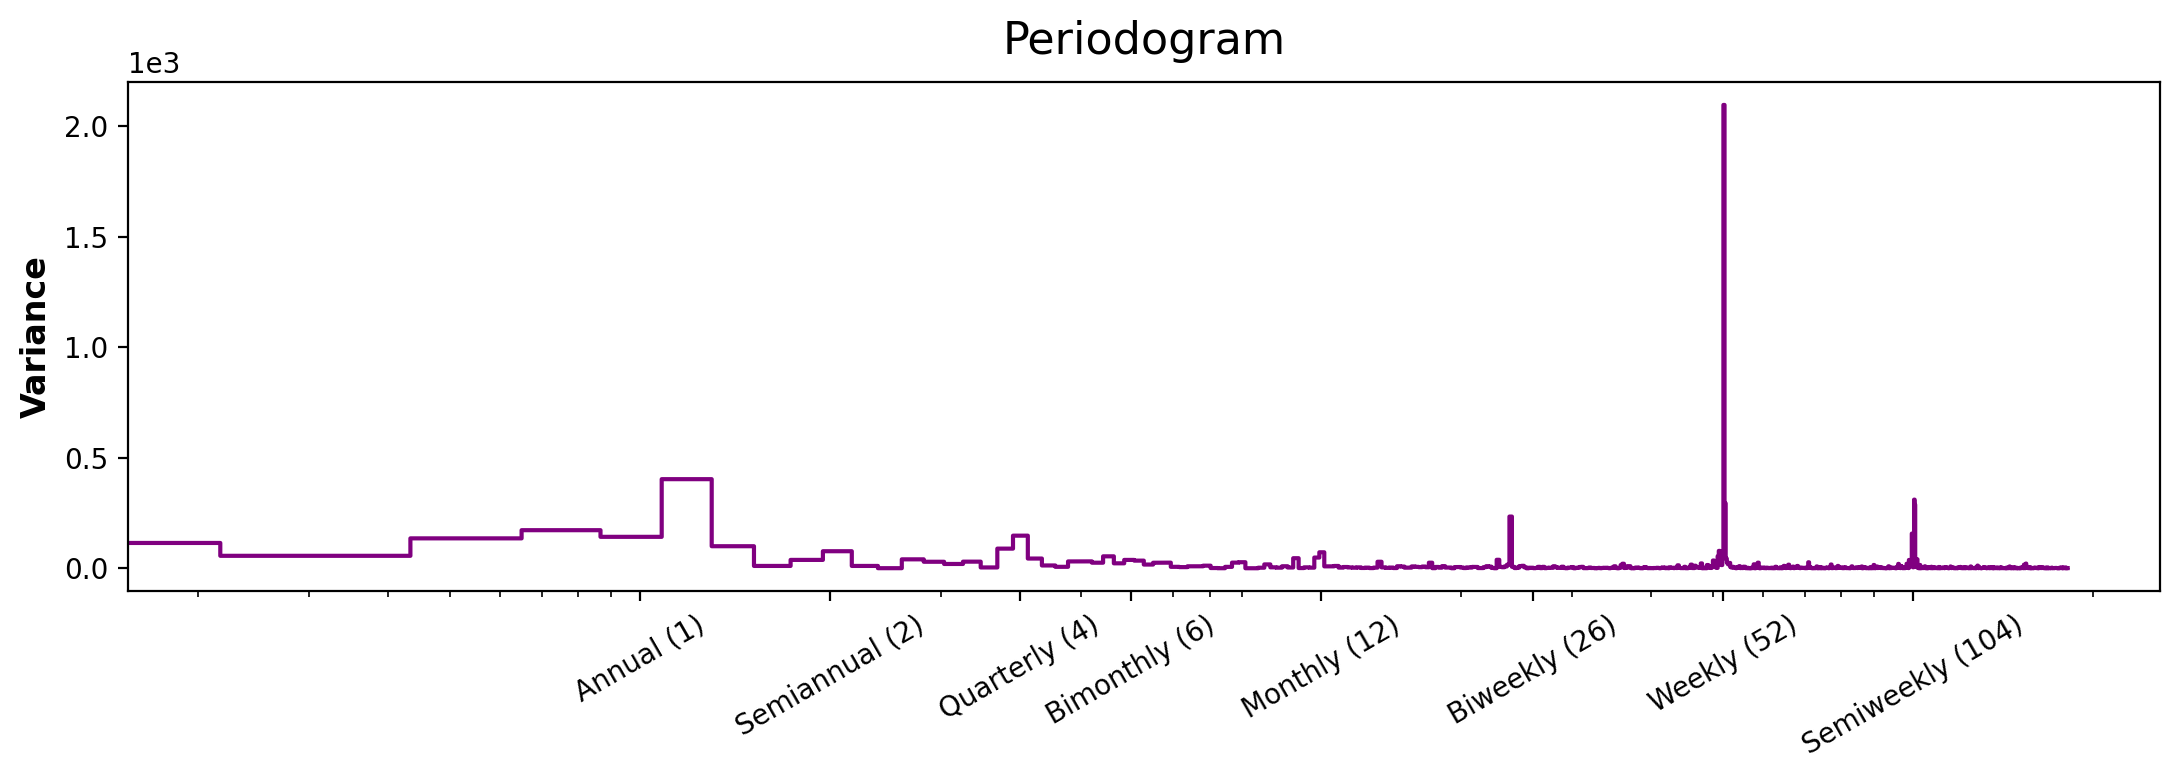

In [18]:
# Here we defined a peiodogram plot that tells us the type of seasonality in our data
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

# Astore_sales_suming your sales data is in a DataFrame named 'sales_data' with a datetime index
# Adjust this according to your actual data structure
sales_data = pd.DataFrame({'sales': np.random.rand(365)}, index=pd.date_range('2022-01-01', '2022-12-31', freq='D'))

# Use the custom plot_periodogram function
plot_periodogram(store_sales_s.sales)
plt.show()


From periodogram we can see a peak at weakly frequency indication that there is a weakly seasonality.
Also there is yearly seasonality and a biweakly seasonality

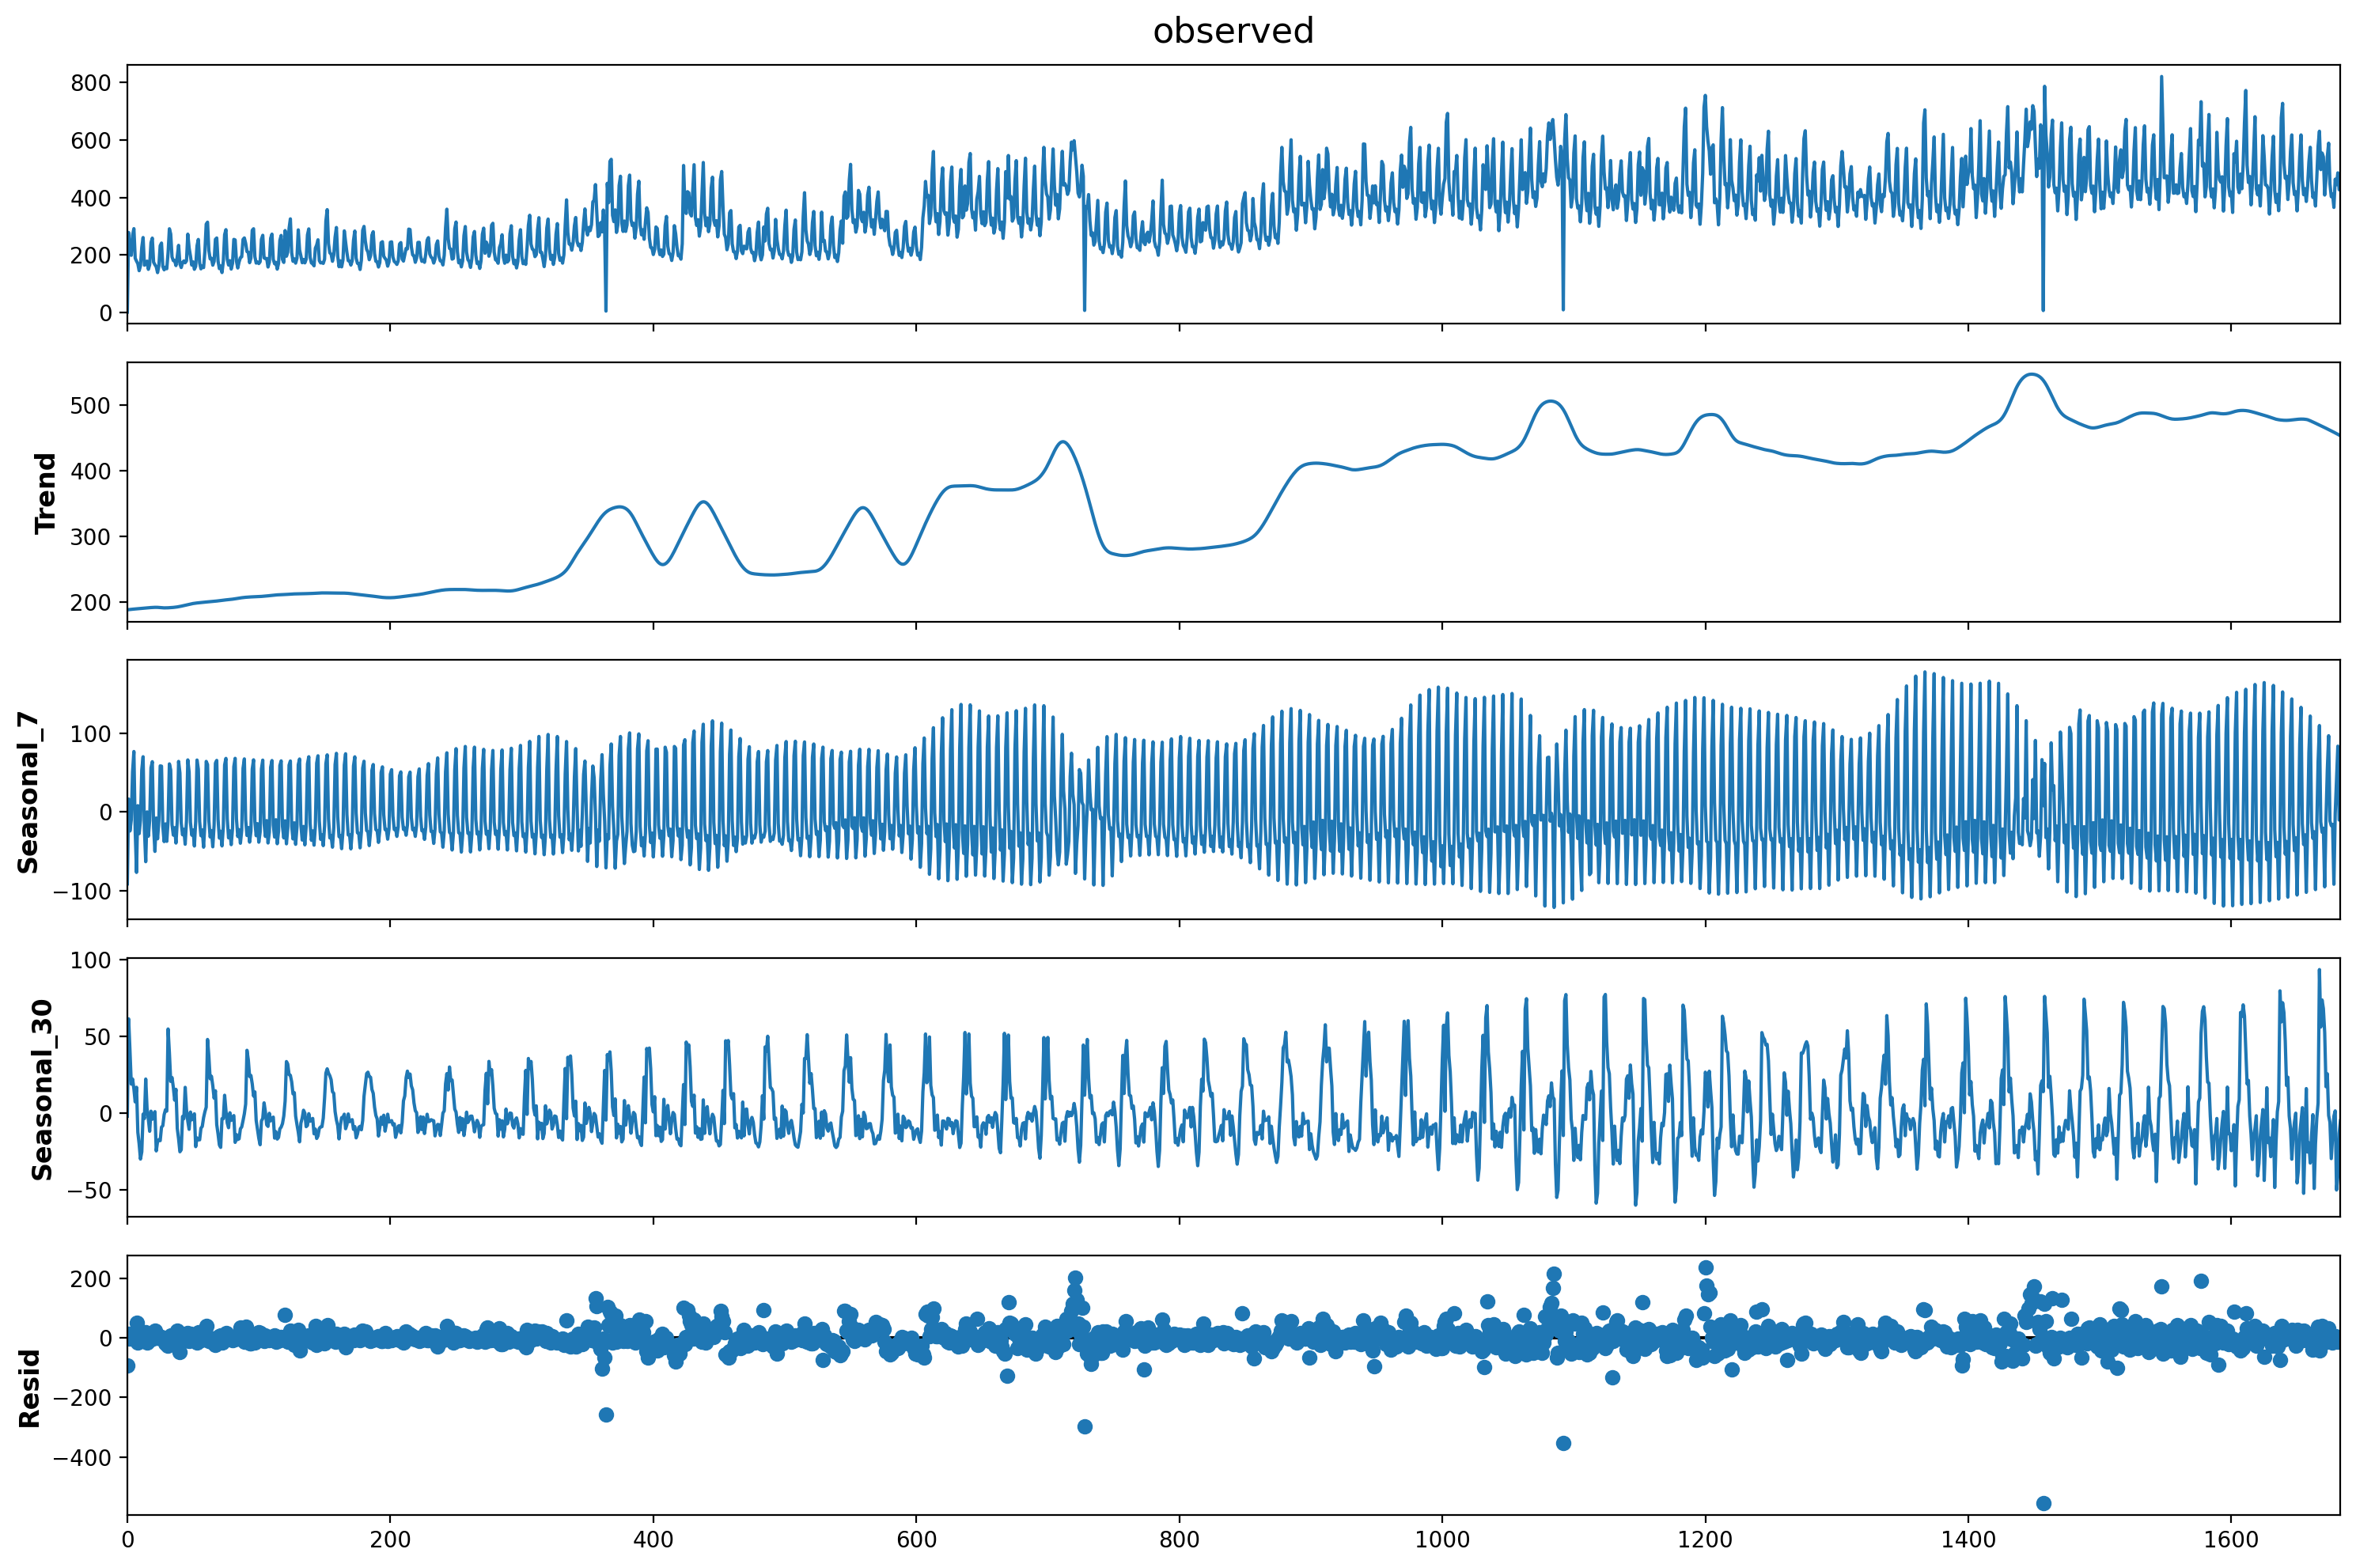

In [19]:
# Decomposing sales data to check the seasonality in the sales using MSTL from statsmodels libraray
res = MSTL(store_sales_s['sales'], periods=(7, 30)).fit()
# increase the figure size
plt.rcParams['figure.figsize'] = (15, 10)
# Plot the results
res.plot()
plt.show()

 This seasonal decompose show that that there are weekly and monthly season in the sales

In [20]:
# Getting the week day, month day and year day from date data in store_sales_s
store_sales_s['week_day'] = store_sales_s.date.dt.weekday
store_sales_s['month_day'] = store_sales_s.date.dt.day
store_sales_s['year_day'] = store_sales_s.date.dt.day_of_year


/tmp/ipykernel_26/848571630.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=store_sales_s, x='week_day',marker='o', y='sales', ci=None, color='blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


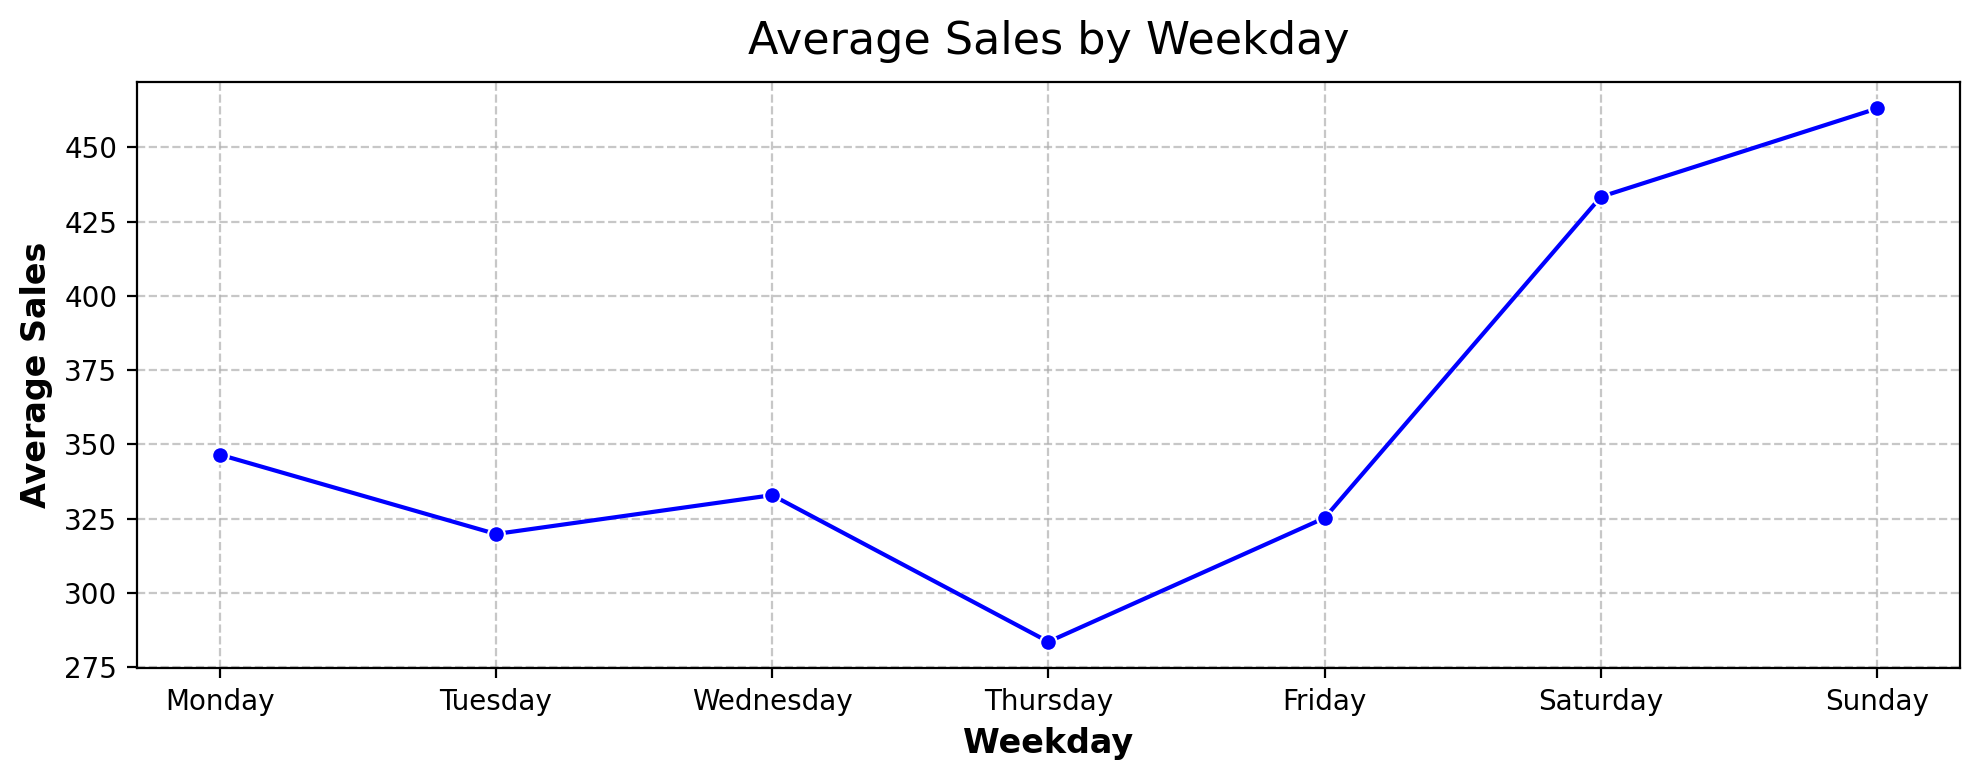

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Astore_sales_suming store_sales_s has a 'week_day' column
plt.figure(figsize=(10, 4))

# Plot using seaborn and matplotlib
sns.lineplot(data=store_sales_s, x='week_day',marker='o', y='sales', ci=None, color='blue')

# Adding title and labels
plt.title('Average Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=range(7), labels=weekday_names)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


We have a good weekly seasonality as there are high sales on weekends

/tmp/ipykernel_26/3170214554.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=store_sales_s, x='month_day',marker='o', y='sales', ci=None, color='blue')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


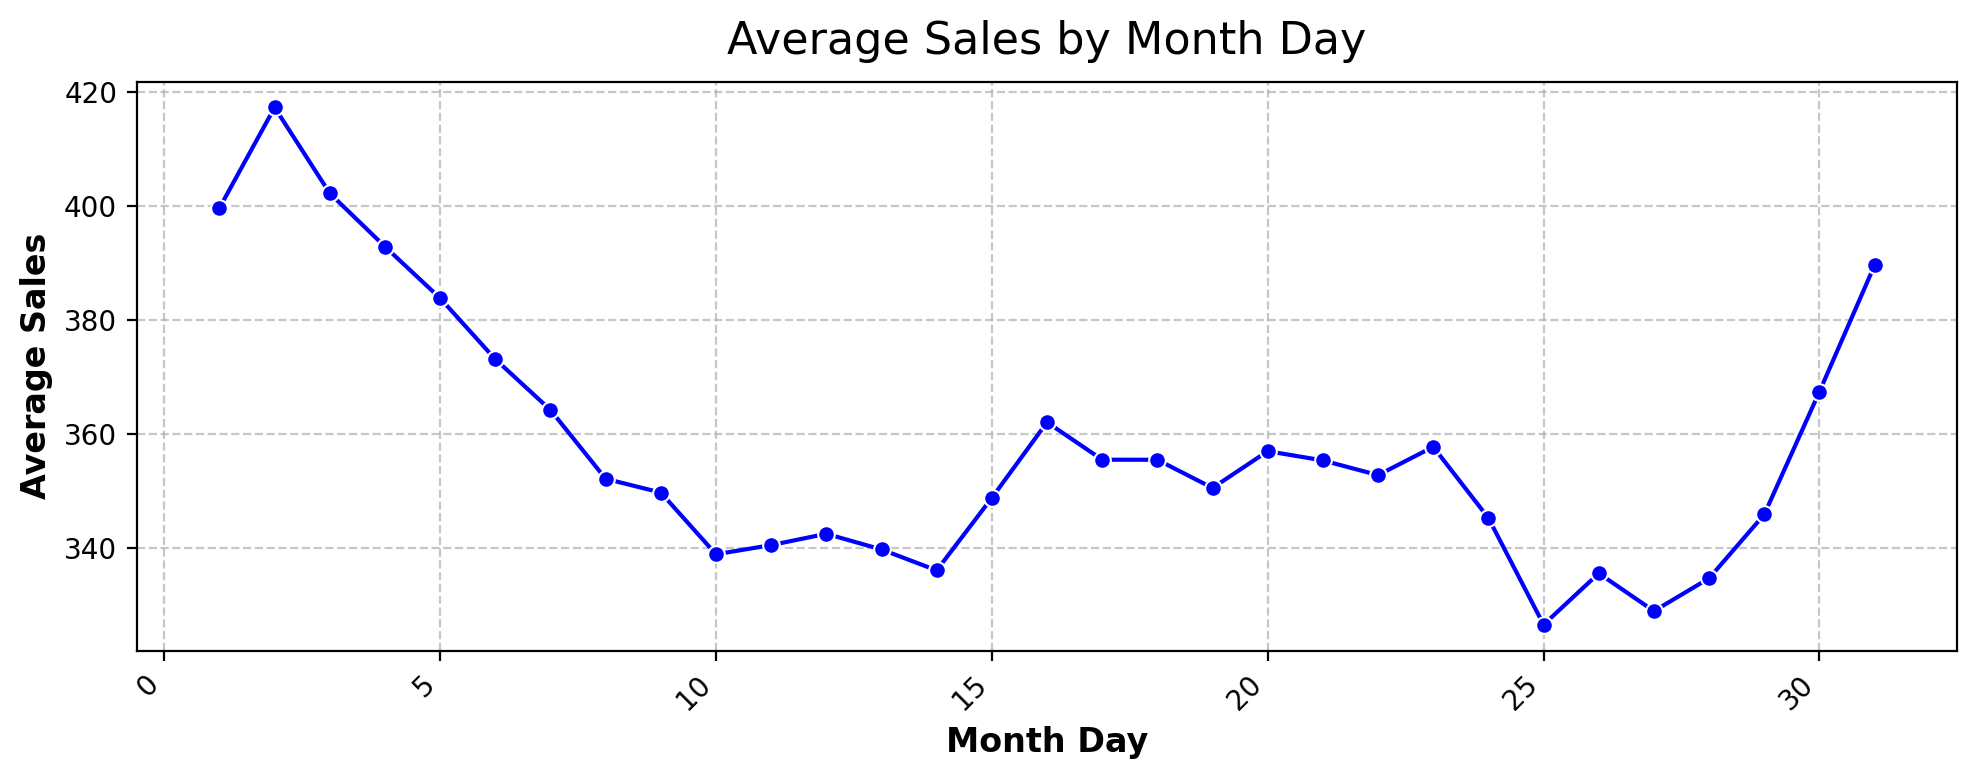

In [22]:
# Checking the monthly seasonality in the data using the month_day column
import seaborn as sns
import matplotlib.pyplot as plt

# Astore_sales_suming store_sales_s has a 'month_day' column
plt.figure(figsize=(10, 4))

# Plot using seaborn and matplotlib
sns.lineplot(data=store_sales_s, x='month_day',marker='o', y='sales', ci=None, color='blue')

# Adding title and labels
plt.title('Average Sales by Month Day')
plt.xlabel('Month Day')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Sales are greater at the start of the month and we can see another pump at the middle of the month. this can be due to the fact that the wages are paid twice a month(at the start of the month and at the middle of the month) resulting in biweakly seasonlity

/tmp/ipykernel_26/2722644629.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=store_sales_s, x='year_day', y='sales', ci=None, color='blue', label='Average Sales')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


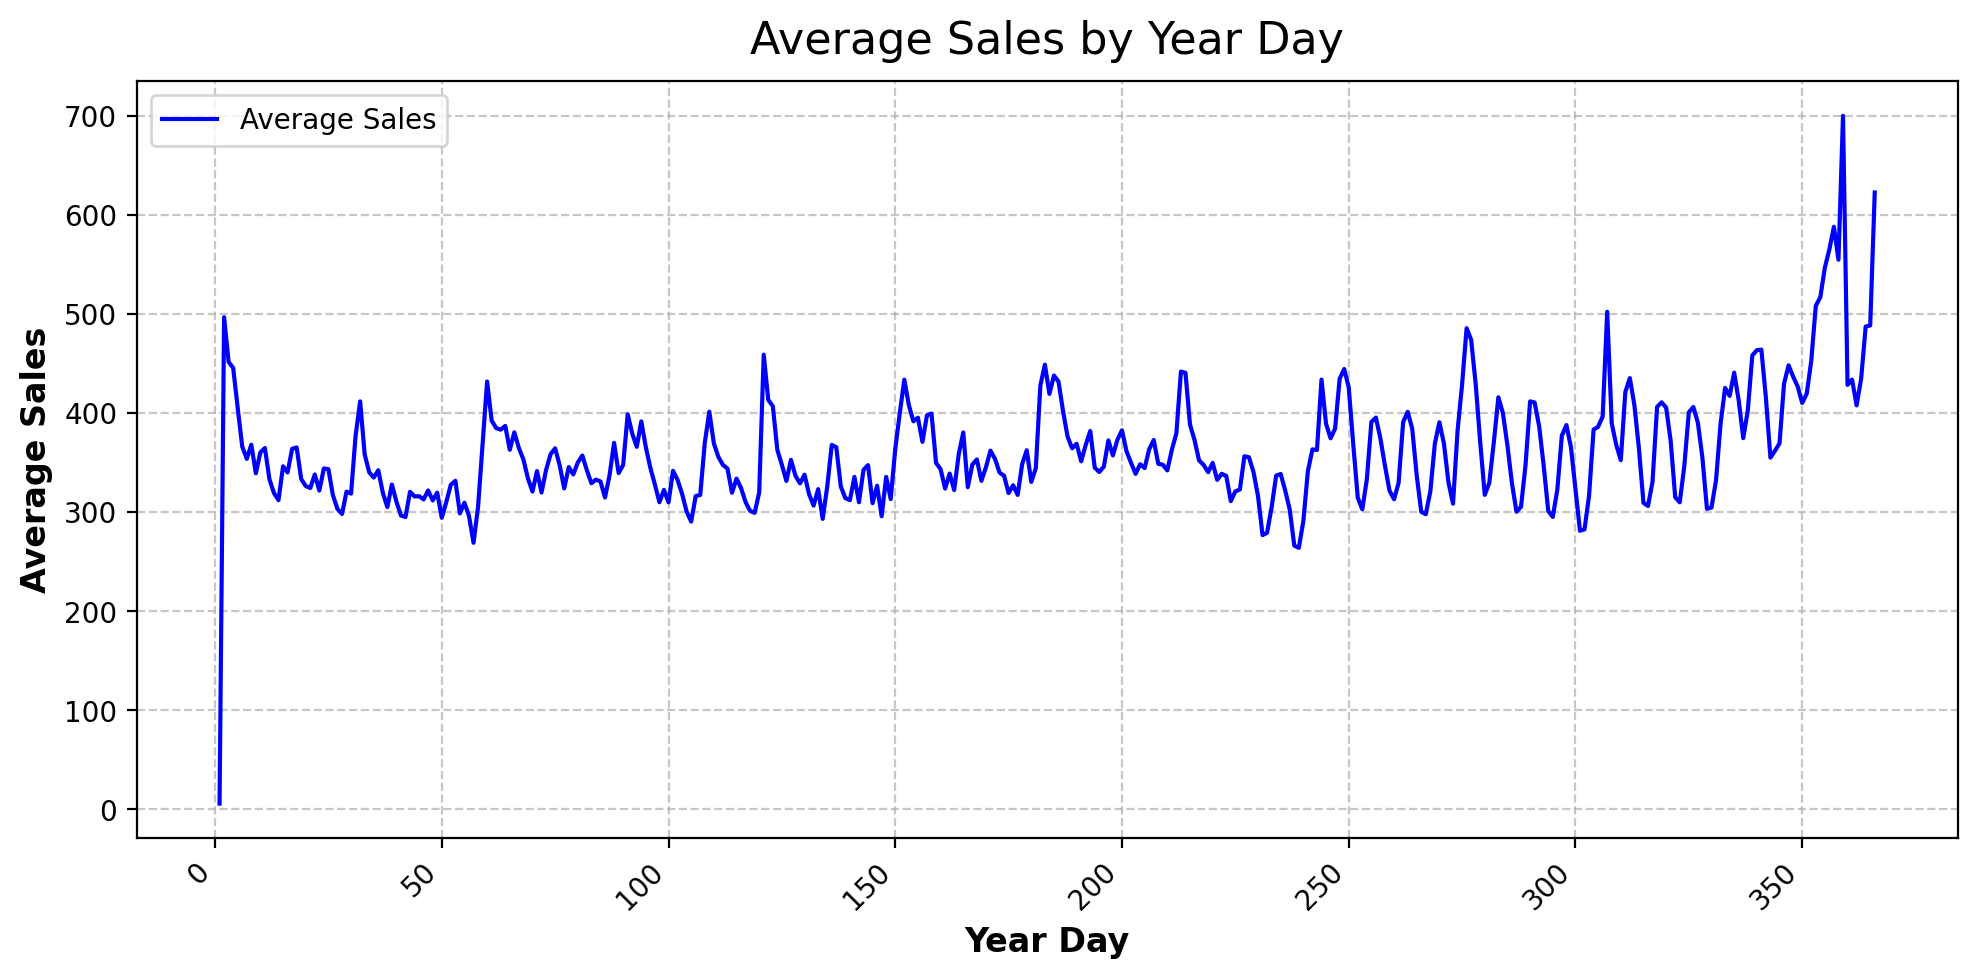

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Astore_sales_suming store_sales_s has a 'year_day' column
plt.figure(figsize=(10, 5))

# Plot using seaborn and matplotlib
sns.lineplot(data=store_sales_s, x='year_day', y='sales', ci=None, color='blue', label='Average Sales')

# Adding title and labels
plt.title('Average Sales by Year Day')
plt.xlabel('Year Day')
plt.ylabel('Average Sales')

# Customizing the x-axis labels
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better readability

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


We can seee that the sales are greater at the end of the year mainly due to chrismas
We can also see that the sales dump on the first day of the year for some reason so we will add a binary column that indicates the first day of year

# Preprocessing

Now that we have done all the analysis. We will start comcining all our datasets and make dataset for training the models on test sets and testing the models on test sets

Before starting this I need to tell you that we will use hybrid model; training two models and getting prediction from both models and comcining them(one is linear model for capturing linear trends and other one is a complex model to learn complex pattern in the time series).

Hybrid model technique is very common is time series forecasting as some models are good at learning linear trends(Linear Regression) while other are good at learning complex pattern(xgboost).

So for hybrid models we have to make to training dataset;one dataset for linear model and one for non_linear model. I will call linear training dataset "x1", non_linear training dataset "x2" and linear testing dataset "test1" and non_linear testing dataset "test2".

we will need to do some preprocessing in the non_linear training and testing datasets so i will initiate them with the prefix "i" meaning "initial".

In [24]:
# Creating the initial training features dataset
x2_ii = (
    store_sales
    .groupby(['store_nbr','date'])
    .mean()['onpromotion']
    .unstack('store_nbr')
)

# Creating the training target dataset
y = (
    store_sales
    .unstack(['store_nbr','family'])
    .loc[:,'sales']
)

# Making the initial testing features dataset
test_ii = (
    test
    .groupby(['store_nbr','date'])
    .mean()['onpromotion']
    .unstack('store_nbr')
)

'''# Changing the order of the columns in x2_i to the test_i
test_ii.columns = test_ii.columns.astype(str)
x2_ii = x2_ii[test_ii.columns]'''

/tmp/ipykernel_26/1507168421.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['store_nbr','date'])
/tmp/ipykernel_26/1507168421.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['store_nbr','date'])


'# Changing the order of the columns in x2_i to the test_i\ntest_ii.columns = test_ii.columns.astype(str)\nx2_ii = x2_ii[test_ii.columns]'

Now that we initiated the non_linear datasets as "x1_i" and "test_i", we will create linear datasets for training "x1" and testing "test1"

In [25]:
# Creating linear datasets using the deterministic process from statsmodels libraray
dp_t = DeterministicProcess(index=x2_ii.index, # Index
                            order=1, # Order of the polynomial
                            drop=True)

x1 = dp_t.in_sample()
test1 = dp_t.out_of_sample(16)

Now as i sad earlier we will do some preprocessing on the inintial non_linear training  and testing dataset

In [26]:
# Merging x2_i dataset and holidays dataset that we created earlier
x2_i = x2_ii.merge(holidays_N_OH, how='left', left_index=True, right_index=True)
# Merging test_i dataset and holidays dataset that we created earlier
test_i = test_ii.merge(holidays_N_OH, how='left', left_index=True, right_index=True)
# Filling the NaN values with zero
x2_i.fillna(0, inplace=True)
test_i.fillna(0, inplace=True)

# Merging x2_i dataset and oil_prices dataset and doing some preprocessing
x2_i = x2_i.merge(oil_prices, how='left', left_index=True, right_index=True)
x2_i['dcoilwtico'].fillna(method='ffill', inplace=True)
x2_i['dcoilwtico'].fillna(method='bfill', inplace=True)

# Mergingx_test_i dataset and oil_prices dataset and doing some preprocessing
test_i = test_i.merge(oil_prices, how='left', left_index=True, right_index=True)
test_i['dcoilwtico'].fillna(method='ffill', inplace=True)
test_i['dcoilwtico'].fillna(method='bfill', inplace=True)

/tmp/ipykernel_26/2864612541.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x2_i['dcoilwtico'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_26/2864612541.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x2_i['dcoilwtico'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_26/2864612541.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

Now we will add some features that will capture seasonality based on the seasonality that we observed above

In [27]:
# Getting the week day, month day and year day from date data in x2_i
x2_i['week_day'] = x2_i.index.weekday
x2_i['month_day'] = x2_i.index.day
x2_i['year_day'] = x2_i.index.day_of_year

# Getting the week day, month day and year day from date data in test_i
test_i['week_day'] = test_i.index.weekday
test_i['month_day'] = test_i.index.day
test_i['year_day'] = test_i.index.day_of_year

# Creating a feature that gives True if it's the first day of the year and False if it's not the first day of the year
x2_i['First_day_of_year'] = x2_i.index.strftime('%m-%d') == '01-01'
# Replacing the True and False in first day of year column wiht 0 and 1 for machine learning model
x2_i['First_day_of_year'] = x2_i.First_day_of_year.apply(lambda x: 0 if x == False else 1)

# Creating a feature that gives True if it's the first day of the year and False if it's not the first day of the year
test_i['First_day_of_year'] = test_i.index.strftime('%m-%d') == '01-01'
# Replacing the True and False in first day of year column wiht 0 and 1 for machine learning model
test_i['First_day_of_year'] = test_i.First_day_of_year.apply(lambda x: 0 if x == False else 1)


For capturing long term seasonality we will use calender fourier from statsmodels library and create 2 new dataset that we will merge later with the original initial datasets to make our final dataset

In [28]:
# Creating fouriers features for longer seasonlity
fourier = CalendarFourier(freq='M', order=4)
# Creating deterministic process to create fourier features and indicators
dp_s = DeterministicProcess(index=x2_i.index,
                          constant=True,
                          seasonal=True,
                          additional_terms=[fourier],
                          drop=True)
x2_d = dp_s.in_sample()
test_d = dp_s.out_of_sample(16)

# deterministic process from statsmodels library help us to make seasonal features from the time series data.
# You can learn more about it in there documentation at there website

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:568: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


Now we will merge both dataset(initial and deterministic process) to make final non_linear dataset

In [29]:
# Now creating the final non_linear training dataset called x2 by combining x2_i and x2_d
x2 = x2_i.merge(x2_d, how='left', left_index=True, right_index=True)

# Now creating the final non_linear testing dataset called test2 by combining test_i and test_d
test2 = test_i.merge(test_d, how='left', left_index=True, right_index=True)

Now we have created all the dataset. Lets summerize:

1) Linear training features dataset = x1

2) Non_linear training features dataset = x2

3) Training targets = y(will be used with both linear and non_linear training features dataset)

4) Linear testing features dataset = test1

5) Non_linear testing features dataset = test2(Testing target are not available as we have to predict them for the kaggle competition)

# Modeling with hybrid model

For Modeling we will define our own class to make the code more concise, easy and reuseable.

Now let me tell you how hybrid modeling is done. First we train a model to fit trend(linear) component of time series and then we subtract the fitted trend(detrending) to remove the linear component from the time series.
Then for the remaining non_linear patterns in the time series we train another complex models.

At the end we will take prediction form both the model on the test set and add their prediction make the final prediction that we will submit to the kaggle competition

In [30]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

Now we will define the fit method in the class

In [31]:
def fit(self, x1, x2, y):
    # fitting self.model_1
    self.model_1.fit(x1,y)

    y_fit = pd.DataFrame(
        # making predictions with self.model_1
        self.model_1.predict(x1),
        index=x1.index, columns=y.columns,
    )

    # computing residuals(detrending)
    y_resid = y - y_fit

    # fitting self.model_2 on residuals
    self.model_2.fit(x2, y_resid)

    # Saving column names for predict method
    self.y_columns = y.columns
    # Saving data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

# Adding method to class
BoostedHybrid.fit = fit

Now we will define the predict method for the class

In [32]:
def predict(self, x1, x2):
    # Predicting with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(x1),
        index=x1.index, columns=self.y_columns,
    )

    # Adding model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(x2)

    return y_pred

# Adding method to class
BoostedHybrid.predict = predict

Now lets call the class and make a validation model to first validate the model

In [33]:
model_valid = BoostedHybrid(
    model_1=LinearRegression(fit_intercept=True),
    model_2=XGBRegressor()
)

Creating our train and validation data

In [34]:
y_train, y_valid = y[:"2017-01-01"], y["2017-01-02":]
x1_train, x1_valid = x1[: "2017-01-01"], x1["2017-01-02" :]
x2_train, x2_valid = x2[:"2017-01-01"], x2["2017-01-02":]

Fitting the model on training and validation data

In [35]:
model_valid.fit(x1_train, x2_train, y_train)

Now lets see how our model performed using visualization

0.7273689847389403


/tmp/ipykernel_26/1151465339.py:14: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
/tmp/ipykernel_26/1151465339.py:15: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


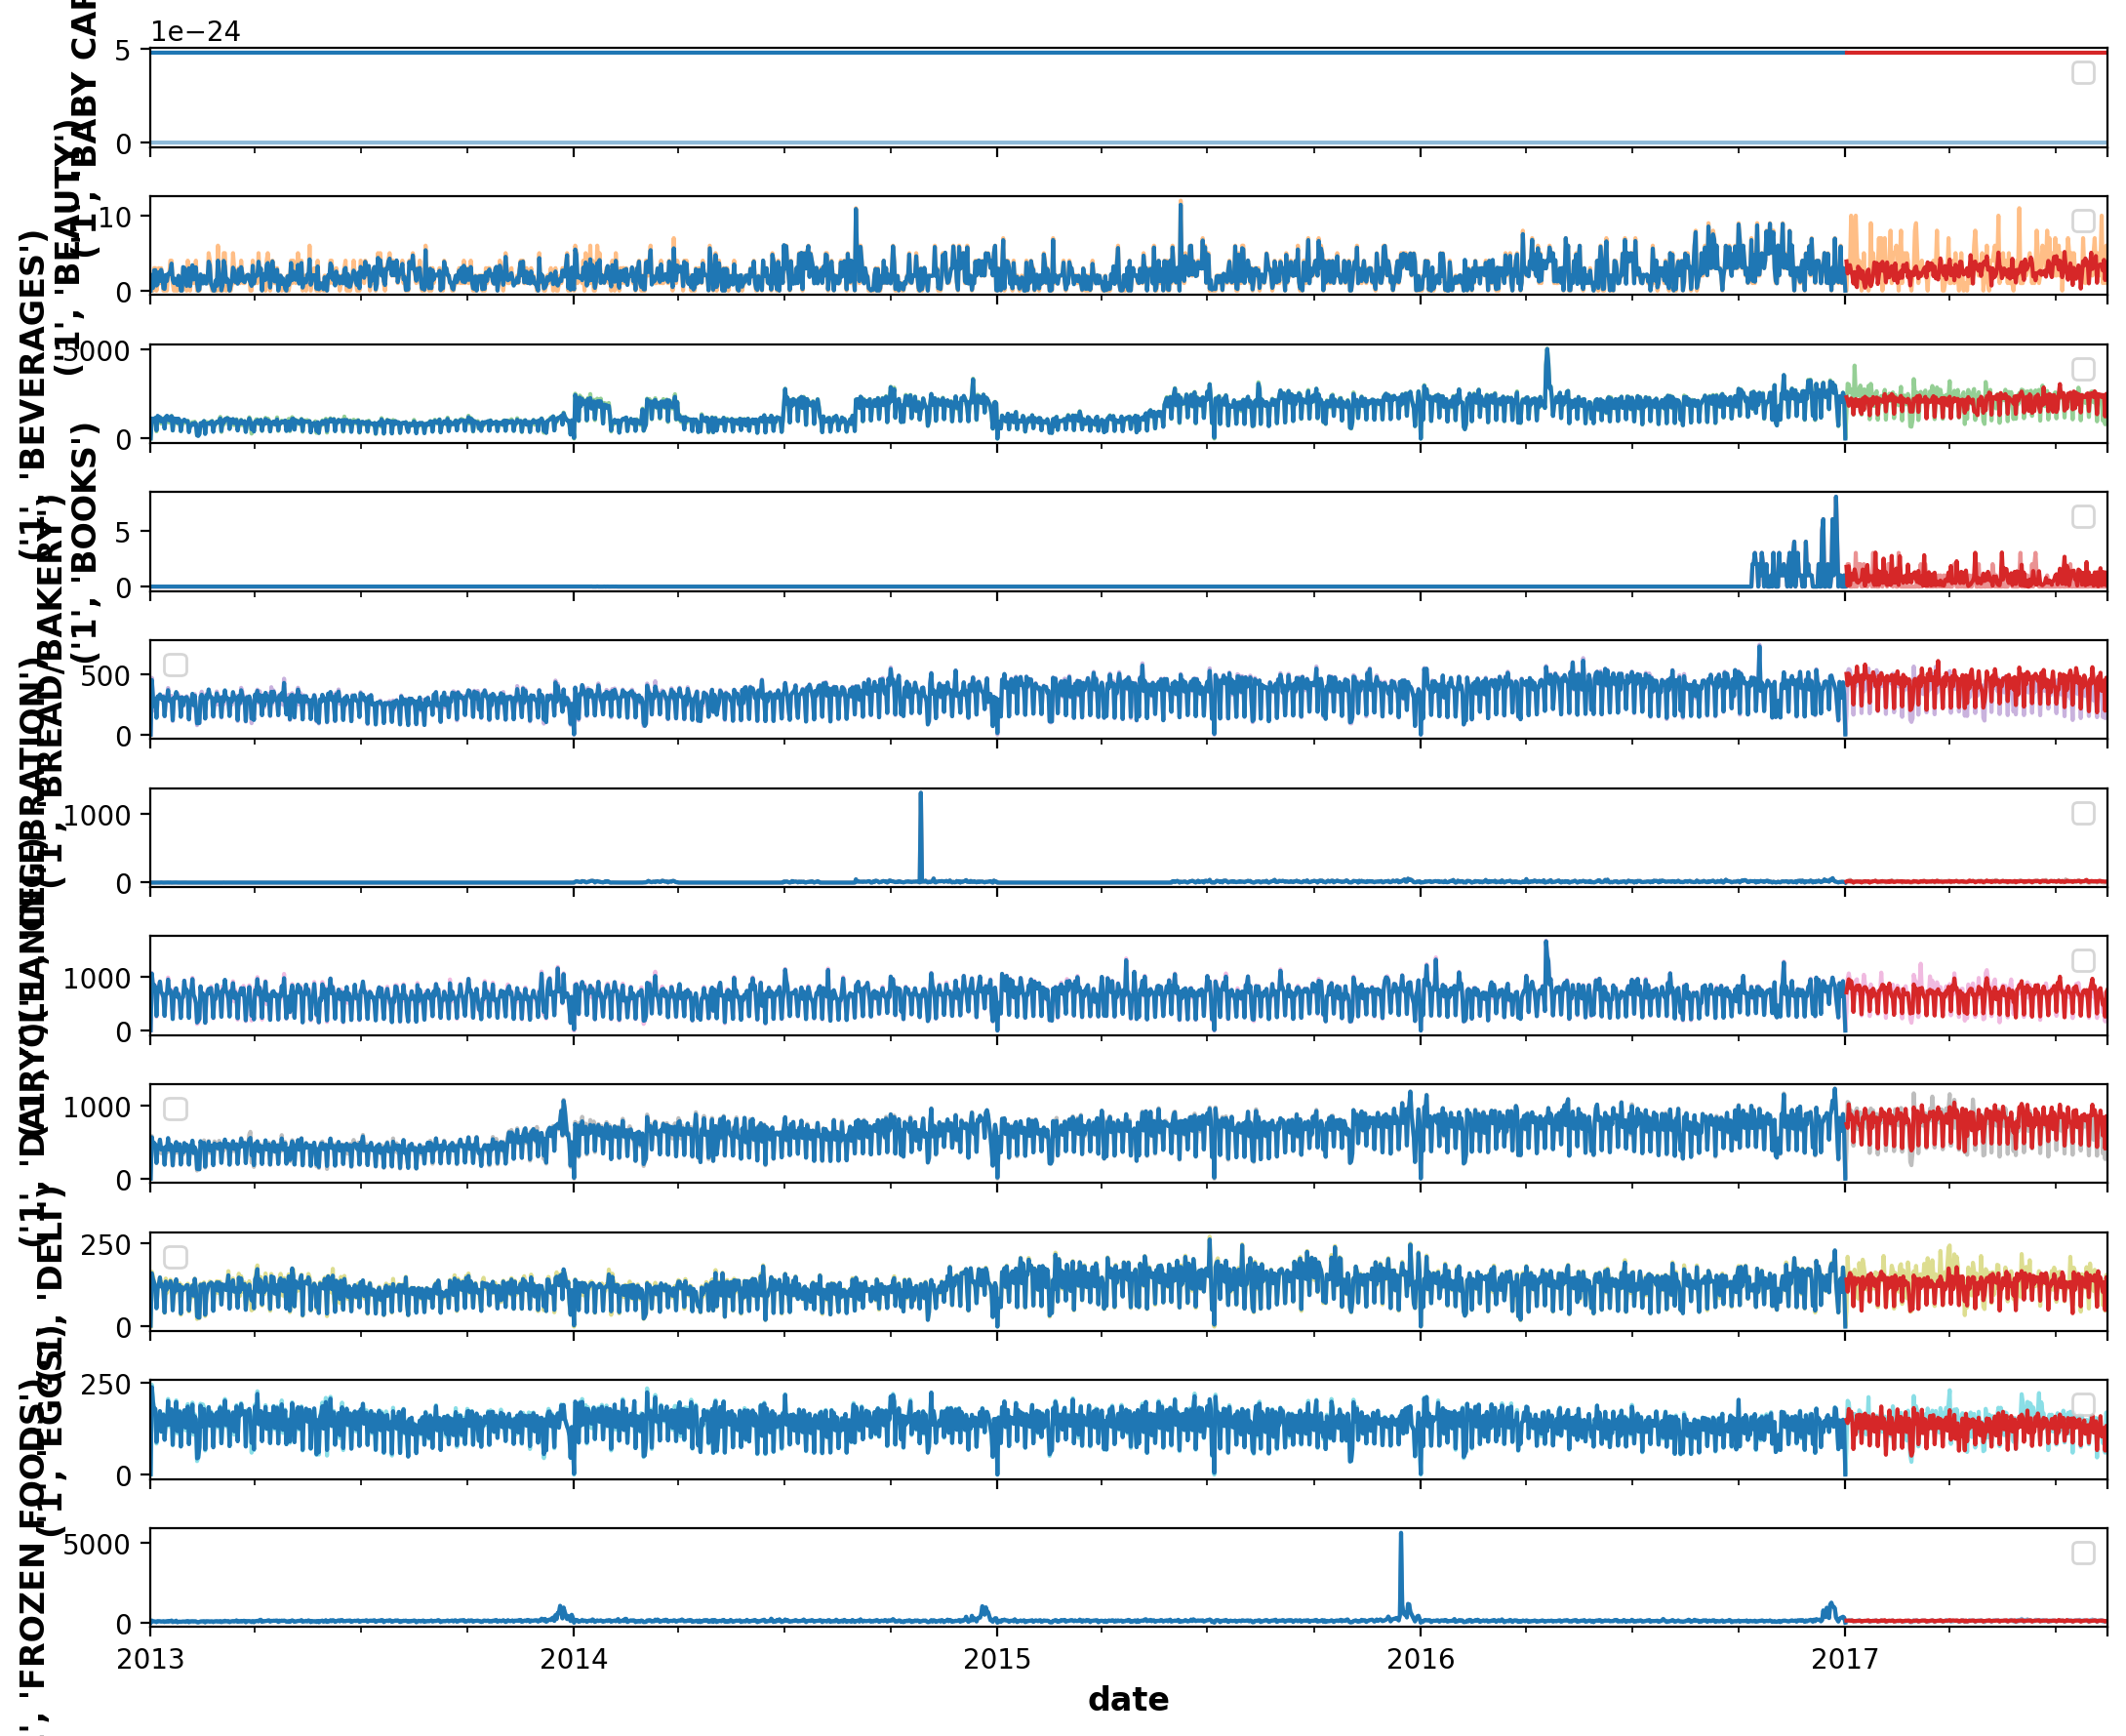

In [36]:
# Making predictions on the training and validation data
y_fit = model_valid.predict(x1_train, x2_train).clip(0.0)
y_pred = model_valid.predict(x1_valid, x2_valid).clip(0.0)

# Calculation the mean_squared_log_error(as it is the evaluation mateix used for the competition)
rmle = sqrt(mean_squared_log_error(y_valid, y_pred))
print(rmle)

# Now lets visualize the prediction for 6 categories
families = y.columns[1:12]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

Overall it did more than i expected(for the first try) but it didn't captured the patterns of some categories. one of which is 'Baby Care'(as you can see on the above plot. Baby care had a straight line for sales but it fitted a line which is very deviated form the actual line and it drastically affected our mean squared log error. If you figured it out let me know in the comment section

Now lets make test model that will be trained on all the data

In [37]:
model_test = BoostedHybrid(
    model_1=LinearRegression(fit_intercept=True),
    model_2=XGBRegressor()
)

Let train it using fit

In [38]:
model_test.fit(x1, x2, y)

Now lets make prediction and make the dataset ready for submission(as required for the the competition).

In [39]:
y_submit = pd.DataFrame(model_test.predict(test1, test2), index=test2.index, columns=y.columns)
y_submit = pd.DataFrame(y_submit.stack(['store_nbr', 'family']))
y_submit = y_submit.join(test.id)
y_submit = y_submit[['id', 0]]
y_submit.rename(columns={0: 'sales'}, inplace=True)
y_submit.to_csv('submission.csv', index=False)
y_submit

/tmp/ipykernel_26/2219308845.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_submit = pd.DataFrame(y_submit.stack(['store_nbr', 'family']))


id         sales
date       store_nbr family                                           
2017-08-16 1         AUTOMOTIVE                  3000888  2.348925e+00
                     BABY CARE                   3000889 -3.154611e-24
                     BEAUTY                      3000890  3.085852e+00
                     BEVERAGES                   3000891  2.965770e+03
                     BOOKS                       3000892  2.187849e+00
...                                                  ...           ...
2017-08-31 9         POULTRY                     3029395  4.042789e+02
                     PREPARED FOODS              3029396  1.245158e+02
                     PRODUCE                     3029397  1.452390e+03
                     SCHOOL AND OFFICE SUPPLIES  3029398  1.438588e+02
                     SEAFOOD                     3029399  1.260313e+01

[28512 rows x 2 columns]